## Chapter 12: Introduction to nonlinear learning

# 12.7 Efficient `model` capacity tuning by boosting

In this Section we introduce the first of two popular, general paradigms for efficient `model` search.   With this first approach - referred to as *boosting* - we take a 'bottom-up' approach to fine tuning the proper amount of capacity a `model` needs.  That is, we begin with a *low capacity* (and likely underfitting) `model`, and then gradually increase its capacity by adding additional units (from the same family of universal approximators) until we achieve a `model` with minimal validation error.  

In [ ]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer and other basic libs
import time
import copy
import math
from IPython.display import clear_output

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 12.7.1  Boosting: the 'bottom-up' approach to capacity tuning

*Boosting* is the general term given to the method of `model` search where we begin with a *low capacity*  `model` - typically consisting of a single feature transformation of the form

\begin{equation}
\text{model}_1\left(\mathbf{x},\mathbf{w}\right) =   w_0 + f_1\left(\mathbf{x}\right){w}_{1}. 
\end{equation}

and we gradually *increase* its capacity by adding units one-at-a-time from the same family of universal approximators (computing the validation error after each unit is added and tuned properly).  If each unit used has low capacity, being e.g., a stump or `tanh` neural network unit, then this approach gives fine-grained control over the total capacity of a `model`.  In other words, *boosting* with inflexible (low-capacity) units allows us to fine-tune the capacity of a `model` as to minimize validation error.

So the second model is constructed by recursively adding a single unit from the same family of universal approximators that $f_1$ belongs too.  So - for example - if $f_1$ were a single layer `tanh` neural network unit, we would then add another unit of the same form to our original model.  So our second $\text{model}_2$ then takes the general form

\begin{equation}
\text{model}_2\left(\mathbf{x},\mathbf{w}\right) =   w_0 + f_1\left(\mathbf{x}\right){w}_{1} + f_2\left(\mathbf{x}\right){w}_{2}. 
\end{equation}

So we can clearly see that our second `model` can be expressed in terms of our first as 

\begin{equation}
\text{model}_2\left(\mathbf{x},\mathbf{w}\right) = \text{model}_1\left(\mathbf{x}\right) + f_2\left(\mathbf{x}\right){w}_{2}
\end{equation}

where here we have left off the weight argument from $\text{model}_1$ to denote that its parameters are fixed.

And we can continue on this way, adding one unit at a time to give our `model` more capacity, so that at the $M^{th}$ step our `model` takes the general form

\begin{equation}
\text{model}_M\left(\mathbf{x},\mathbf{w}\right) =   w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_M\left(\mathbf{x}\right)w_M
\end{equation}

which we can write equivalently and recursively in terms of the $\left(M-1\right)^{th}$ `model` as 

\begin{equation}
\text{model}_M\left(\mathbf{x},\mathbf{w}\right) = \text{model}_{M-1}\left(\mathbf{x}\right) + f_M\left(\mathbf{x}\right){w}_{M}.
\end{equation}


This idea is quite intuitive - we are just building up a set of `models` $\left\{\text{models}_m\right\}_{m=1}^M$ by adding one unit at-a-time, and each subsequent `model` clearly grows in capacity because of it.   However notice that each subsequent `model` also contains additional parameters to tune.  For example, going from the first to second `model` we move from having only $w_0$, $w_1$, and any parameters internal to $f_1$ to tune to having these and $w_2$ as well as any internal parameters of $f_2$ to tune.  So - in other words - if we tune *every* parameter of every `model`, as we progress we have more and more parameters to tune with each and so training (optimization) becomes more costly as we progress from $m=1,...,M$.

The alternative to tuning all the parameters of each `model` is to simply *tune only the parameters of the most recently added unit* each `model`.  How can we do this?  Let us go back to our first `model` $\text{model}_1$ consisting of a single unit $f_1$ shown above in equation (1).  Suppose we have tuned this `model` on a training set and computed its associated validation error.  This means we have tuned the parameters $w_0$, $w_1$, and any internal parameters $f_1$ might have.  Now when we build our second `model` $\text{model}_2$ - by adding the unit $f_2$ - *we keep the weights associated with the first unit fixed at their tuned values*.  This means that in the second `model` we need only tune $w_2$ and any internal parameters of $f_2$.  We can continue this trend so that when adding the $m^{th}$ unit to our `model` (which we write recursively in terms of the $(m-1)^{th}$ `model` as)

\begin{equation}
\text{model}_m\left(\mathbf{x},\mathbf{w}\right) =  \text{model}_{m-1}\left(\mathbf{x}\right) + f_m\left(\mathbf{x}\right)w_m
\end{equation}

we only need tune the parameters of the newly added unit $f_m$, that is the weight $w_m$ and any weights internal to $f_m$ itself (indeed here these are the parameters denoted by $\mathbf{w}$ on the left hand side of the equation).  All of the other weights associated with previously added units - $w_0$, $w_1$,...,$w_{m-1}$ as well as any weights internal to $f_1$ through $f_{m-1}$ - have already been tuned.  By tuning the parameters this way we increase the capacity of each successive `model` while keeping the optimization / training at each step roughly constant - since at each step we tune the parameters of a single unit.  

This combination of building a series of `models` by adding one unit at-a-time - and tuning only the parameters of the unit added keeping all others fixed at their previously tuned values - is referred to as *boosting*.  The sequence of corresponding `models`  $\left\{\text{models}_m\right\}_{m=1}^M$ is referred to as a set of *boosted `models`*.  More generally we can also apply boosting by adding a number $U \geq 1$ units at each step of this process, precisely as outlined above when $U=1$.  

> *Boosting* is a general procedure for determining a `model` with proper capacity based on building a series of `models` recursively one unit (or set o $U$ units) at-a-time, and tuning only the parameters belonging to the most recently added unit(s). 

Question: would our `model` at the $m^{th}$ step (shown above) fit our training data better / result in smaller training error if we tuned all of its parameters *simultaneously* (even if this would become increasingly costly as we add units)?  Yes.  However, remember that our goal is to find a `model` with small *validation error*, so the fact that with boosting (by tuning only the parameters of the most recently added unit) is actually helpful: it means that our sequence of `models` will not overfit nearly as quickly as they would if we tuned all of their parameters simultaneously.

Finally - when do we stop adding units to our `model` with boosting?  We can either choose a maximum number $M$, or halt when we feel that the validation error is small and will likely not get any smaller.  The latter choice is typically based on simple heuristics like halting the procedure a fixed number of steps after a dip in validation error has occurred.

#### <span style="color:#a50e3e;">Example 1. </span> Boosting regression 

Here we illustrate how to boost using `relu` neural network units using a simple regression dataset.  More specifically, we add two `relu` units at-a-time (to emphasize the difference between a `model` with the right amount of capacity and an overfitting one) to our `model`, keeping $\frac{2}{3}$ of the data for training and $\frac{1}{3}$ for validation.   We perform $300$ such boosting steps, and animate $20$ such steps (taken evenly from the full set) in the animation below.  As you move the slider from left to right the boosting steps proceed, with the resulting fit shown in the left panel with the original data (which is color-coded - blue for training and yellow for validation data) and corresponding training / validation errors shown in the right (with blue denoting training error and yellow validation error).  


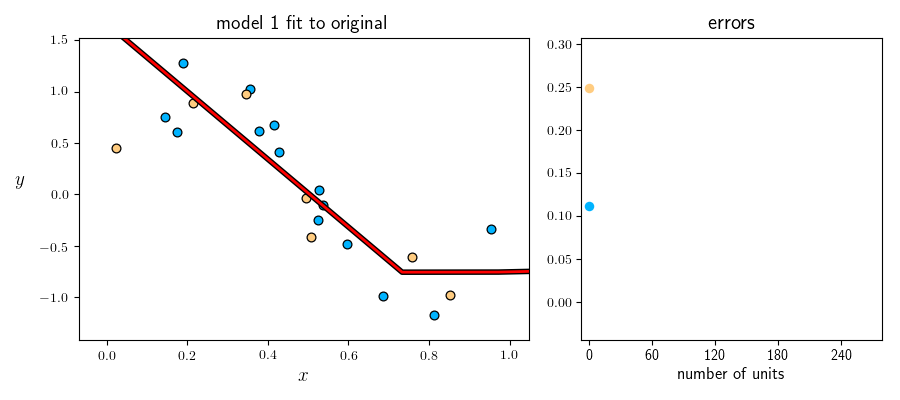
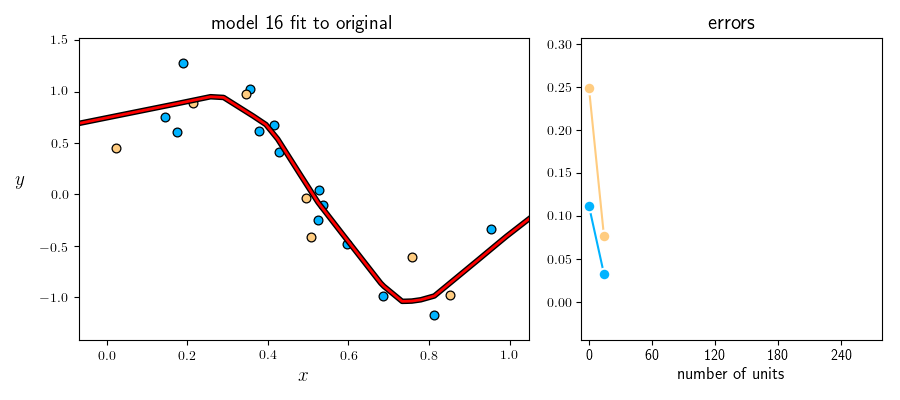
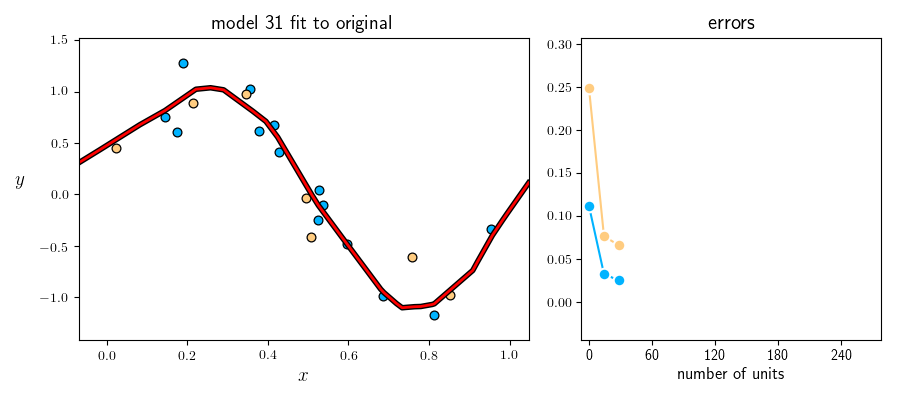
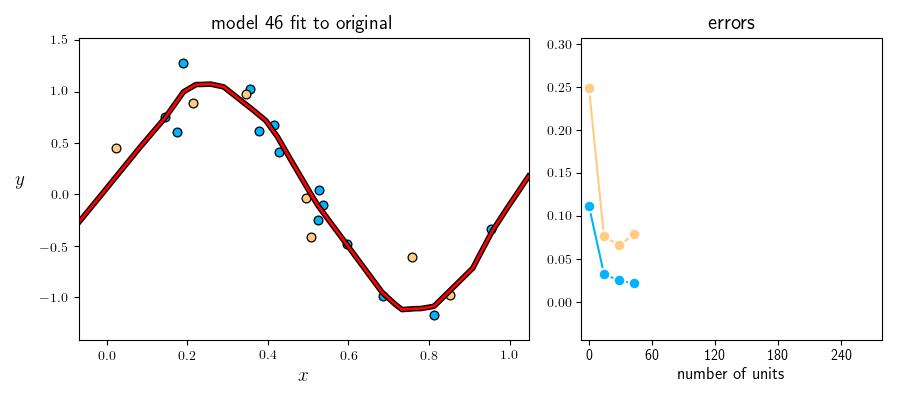
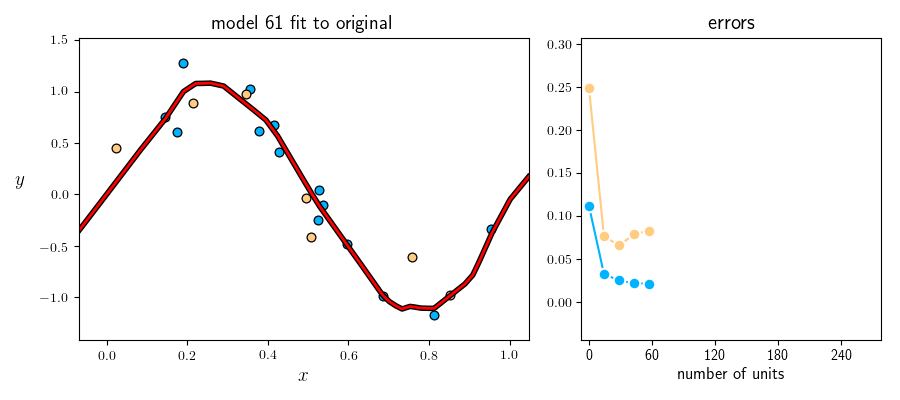
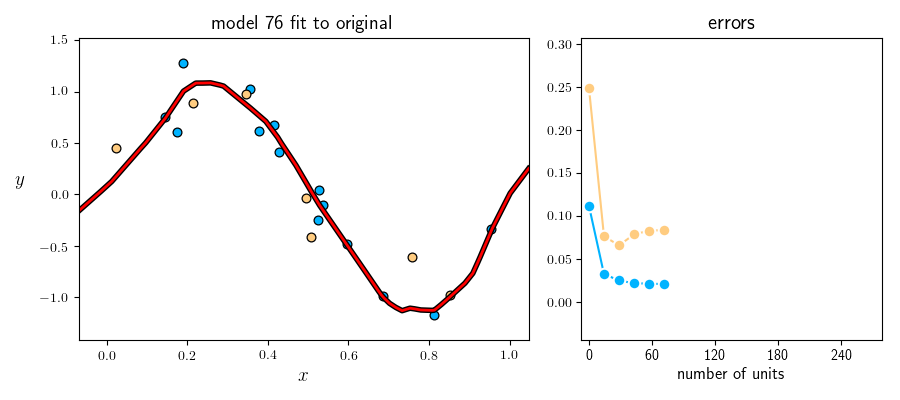
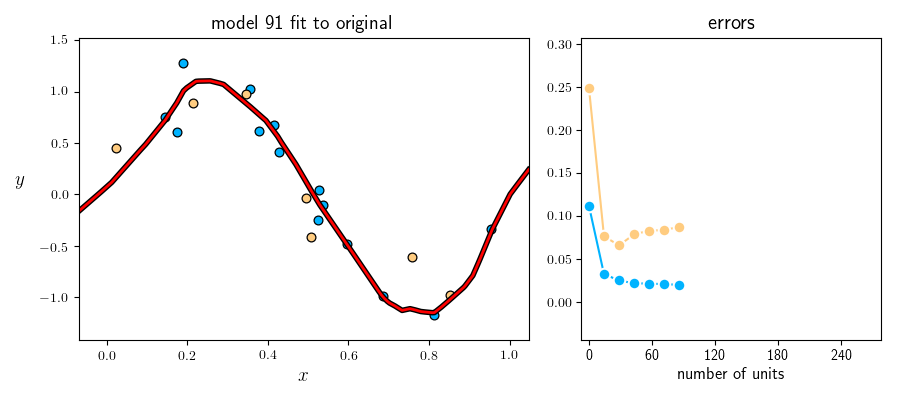
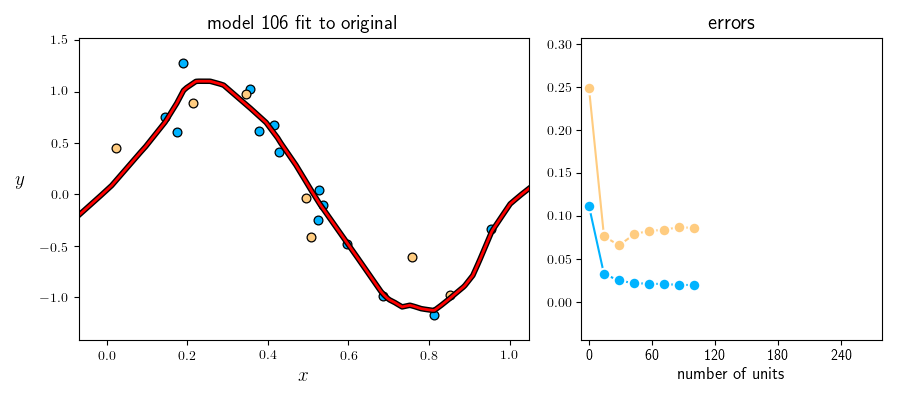
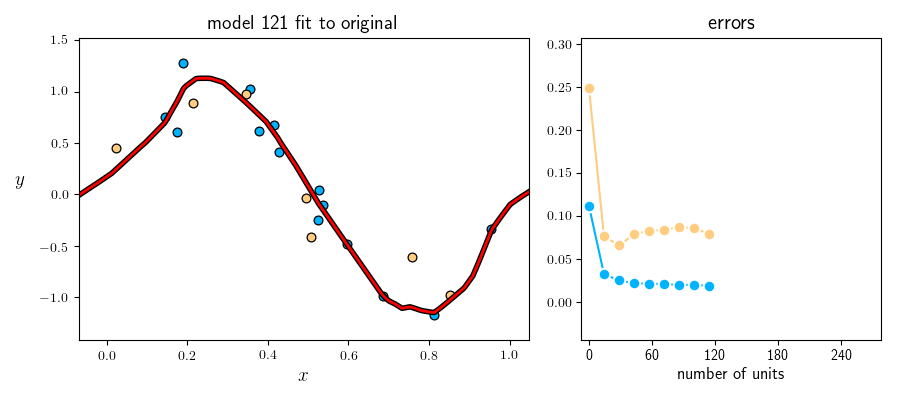
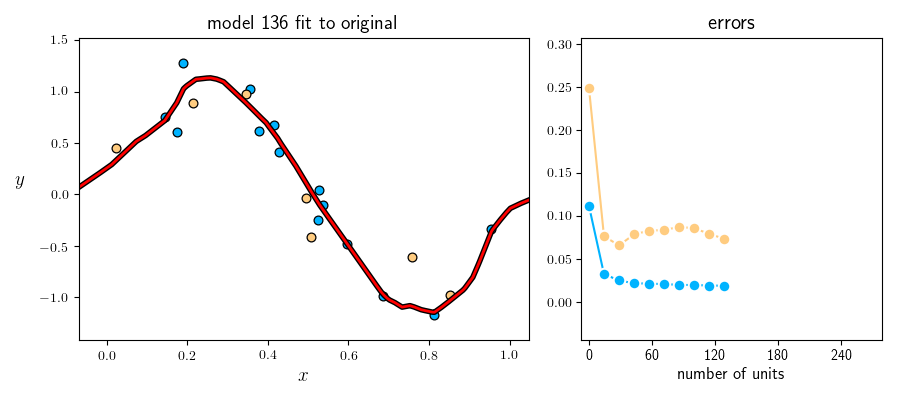
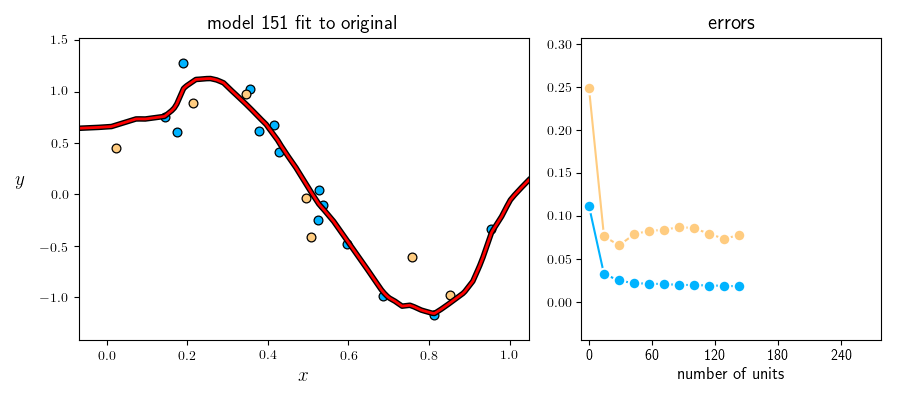
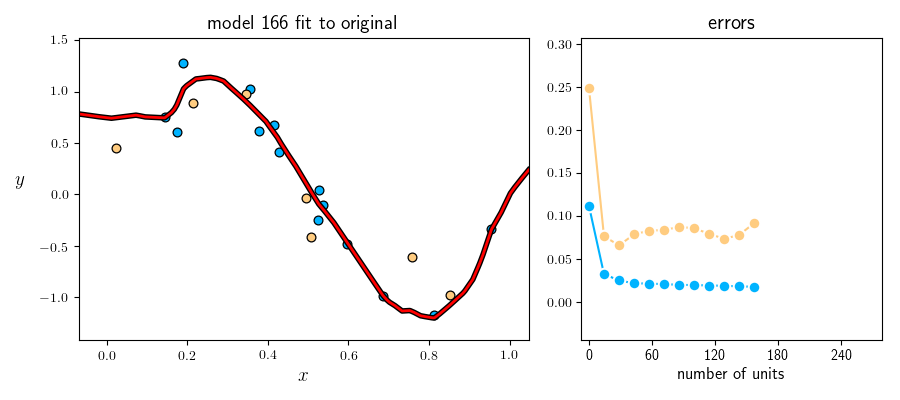
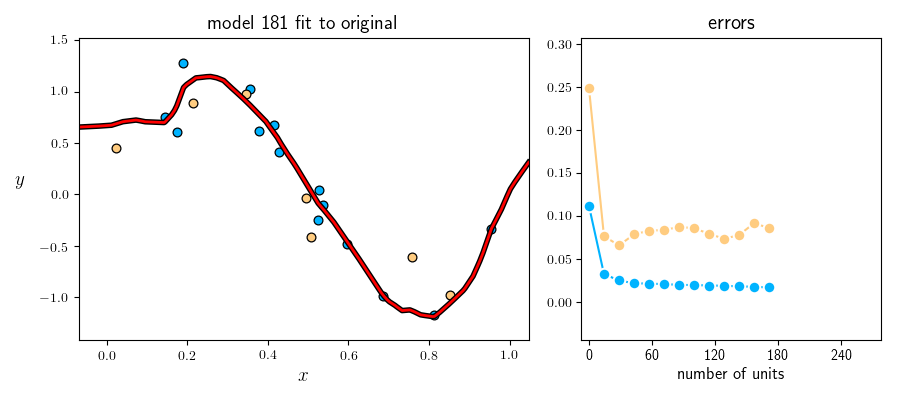
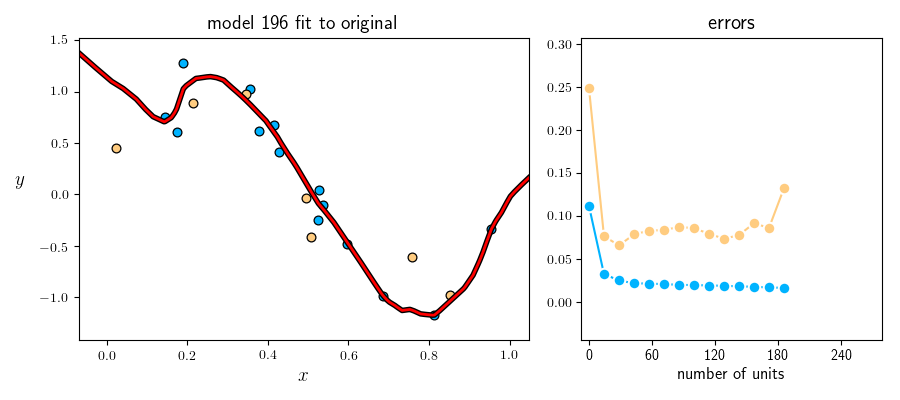
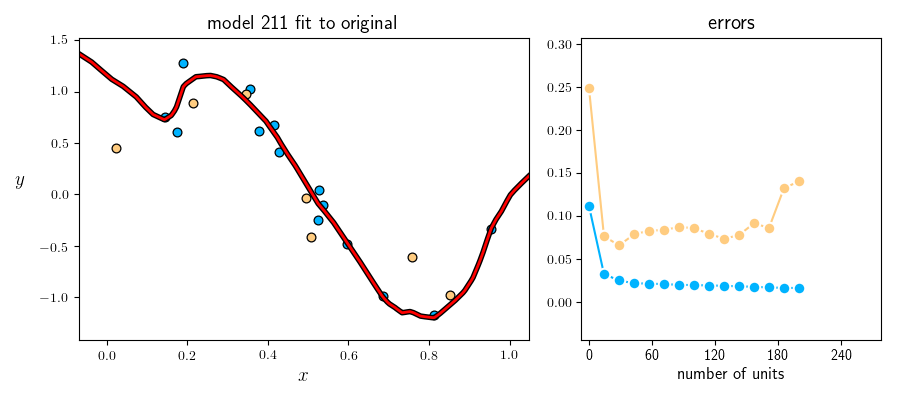
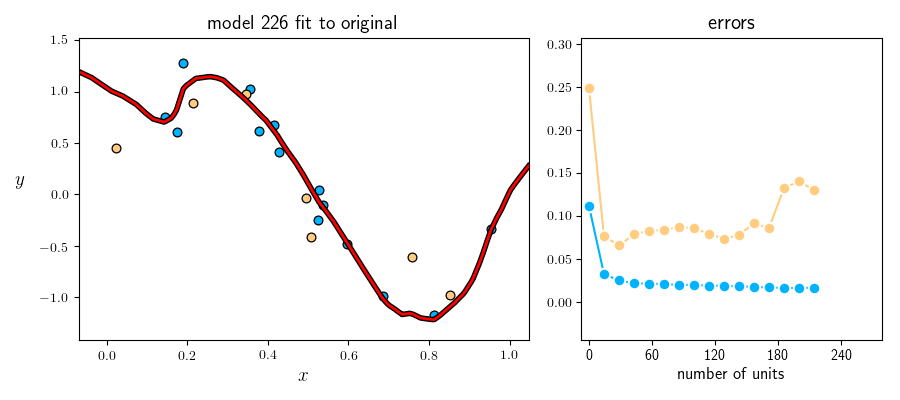
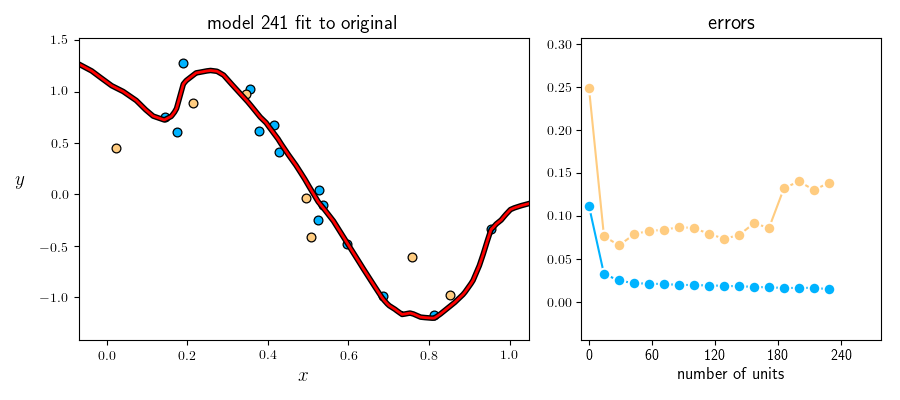
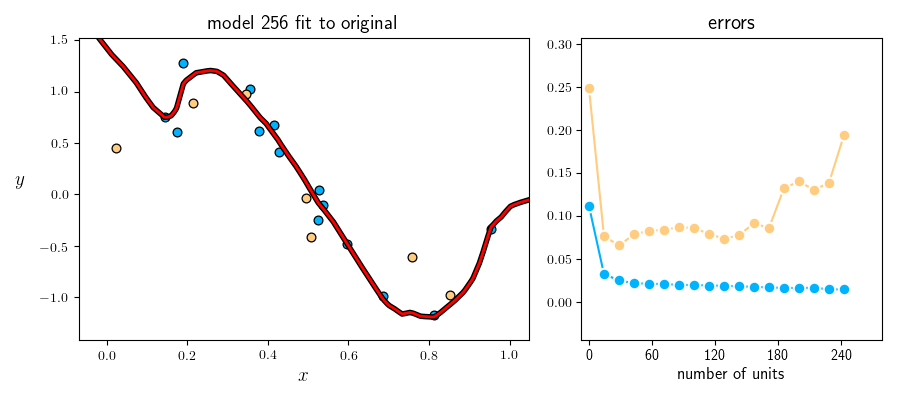
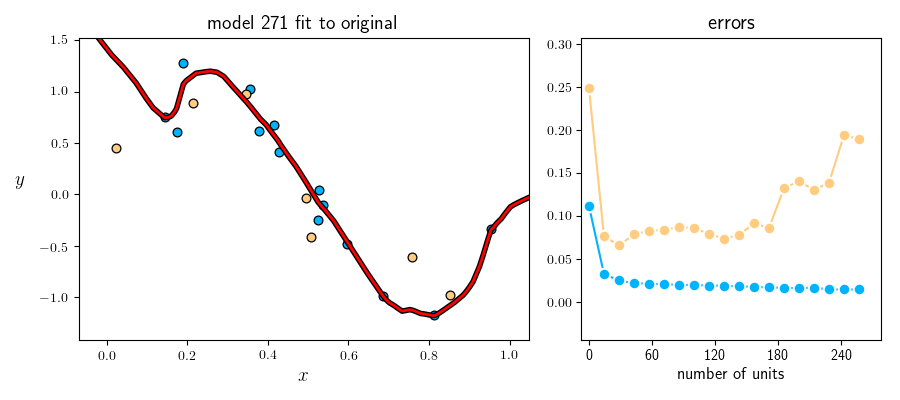
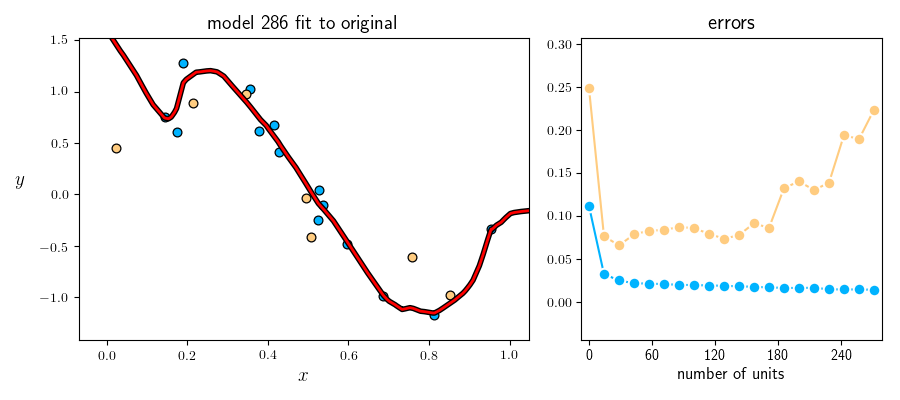

In [44]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
# csvname = datapath + 'universal_regression_samples_0.csv'
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

### boosting ###
num_units = 300
runs1 = []
for j in range(num_units):
    print ('unit ' + str(j) + ' added to model')
    # import the v1 library
    mylib1 = nonlib.library_v2.superlearn_setup.Setup(x,y)

    # choose features
    mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = [1,2,1],activation = 'relu',scale = 0.5)

    # choose normalizer
    mylib1.choose_normalizer(name = 'standard')
    
    # split into training and validation sets
    if j == 0:
        # make training testing split
        mylib1.make_train_valid_split(train_portion = 0.66)
        train_inds = mylib1.train_inds
        valid_inds = mylib1.valid_inds

    else: # use split from first run for all further runs
        mylib1.x_train = mylib1.x[:,train_inds]
        mylib1.y_train = mylib1.y[:,train_inds]
        mylib1.x_valid = mylib1.x[:,valid_inds]
        mylib1.y_valid = mylib1.y[:,valid_inds]
        mylib1.train_inds = train_inds
        mylib1.valid_inds = valid_inds
        
    # choose cost
    mylib1.choose_cost(name = 'least_squares')

    # fit an optimization
    mylib1.fit(max_its = 500,alpha_choice = 10**(-1))

    # add model to list
    runs1.append(copy.deepcopy(mylib1))
    
    # cut off output given model
    normalizer = mylib1.normalizer
    ind = np.argmin(mylib1.train_cost_histories[0])
    weights = mylib1.weight_histories[0][ind]
    y_pred =  mylib1.model(normalizer(x),weights)
    y -= y_pred
    
# report update and clear cell output
print ('finished all ' + str(num_units) + ' steps')
time.sleep(1.5)
clear_output()

# animate the business
frames = 20
demo1 = nonlib.boosting_regression_animators.Visualizer(csvname)
demo1.animate_trainval_boosting(runs1,frames,num_units,show_history = True)

## 12.7.2 The residual perspective with regression

Here we describe a common interpretation of boosting in the context of regression, that of sequentially fitting to the 'residual' of a regression dataset.  To see what this means let us study a regression cost function - here Least Squares - where we have inserted a boosted `model` at the $m^{th}$ step of its development

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_m\left(\mathbf{x}_p,\mathbf{w}\right) - y_p\right)^2.
\end{equation}

 Suppose this boosted `model` has been constructed by recursively adding a single unit at each step of the boosting process.  Since our boosted model is recursive, we can write equivalently as  $\text{model}_m\left(\mathbf{x}_p,\mathbf{w}\right) =   \text{model}_{m-1}\left(\mathbf{x}_p\right) + f_m\left(\mathbf{x}_p\right)w_m$ where all of the parameters of the $\left(m-1\right)^{th}$ `model`, $\text{model}_{m-1}$, are already tuned.  Examining just the $p^{th}$ summand of the cost function above, notice we can re-write it as
 
 \begin{equation}
\left(\text{model}_{m-1}\left(\mathbf{x}_p\right) + f_m\left(\mathbf{x}_p\right)w_m - y_p \right)^2 = \left(f_m\left(\mathbf{x}_p\right)w_m - \left(y_p - \text{model}_{m-1}\left(\mathbf{x}_p\right)\right)\right)^2.
 \end{equation}

On the right hand side we have just re-arranged terms, keeping our term with parameters that still need tuning $f_m\left(\mathbf{x}\right)w_m $ on the left and lumping all of the *fixed* quantities together - i.e., $y_p - \text{model}_{m-1}$ - on the right.  Applying this to each summand of the cost function we can write it equivalently as 

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(f_m\left(\mathbf{x}_p\right)w_m - \left(y_p - \text{model}_{m-1}\left(\mathbf{x}_p\right)\right)\right)^2.
\end{equation}

By minimizing this error notice we look to tune the parameters of a single additional unit so that

\begin{equation}
f_m\left(\mathbf{x}_p\right)w_m\approx y_p - \text{model}_{m-1}\left(\mathbf{x}_p\right) \,\,\,\,\, p=1,...,P
\end{equation}

or in other words, so that this fully tuned unit approximates our original output $y_p$ minus the contribution of the previous model $\text{model}_{m-1}\left(\mathbf{x}_p\right)$.  This quantity - the difference between our original output and the contribution of the $\left(m-1\right)^{th}$ `model` - is often called the *residual*.  It is the 'leftovers', what is left to represent after learning after subtracting off what was learned by the $\left(m-1\right)^{th}$ `model`.

#### <span style="color:#a50e3e;">Example 2. </span> Boosting regression and 'fitting to the residual'

Below we animate the process of boosting $M = 5000$ single layer `tanh` units to a one dimensional input regression dataset.  In the left panel we show the dataset along with the fit provided by $\text{model}_m$ at the $m^{th}$ step of boosting.  In the right panel we plot the *residual* at the same step, as well as the fit provided by the corresponding $m^{th}$ *unit* $f_m$.  As you pull the slider from left to right the run of boosting progresses, with the fit on the original data improving and while (simultaneously) the residual shrinks.


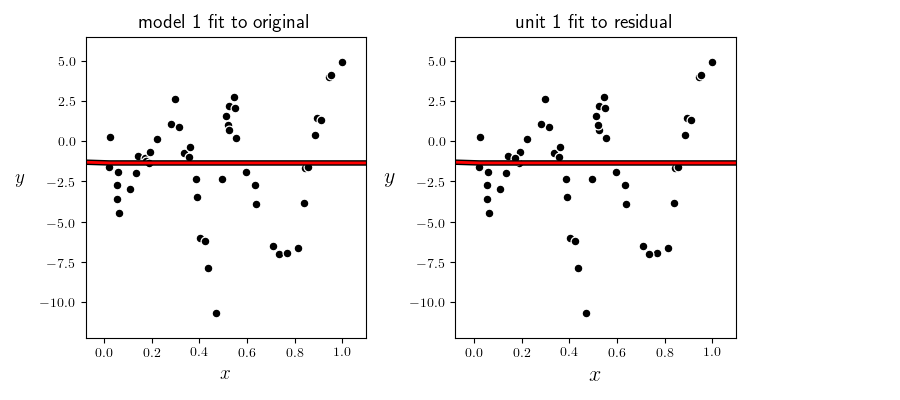
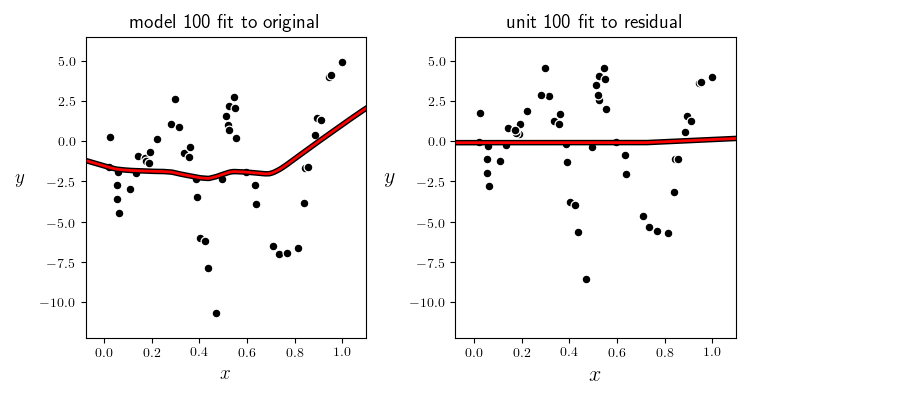
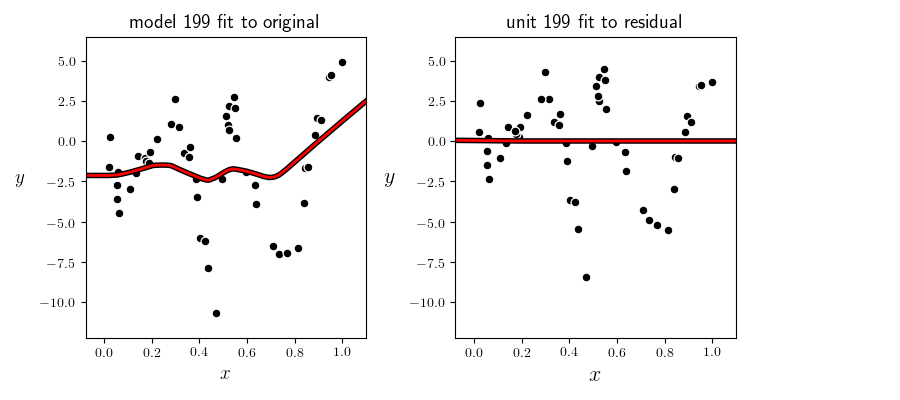
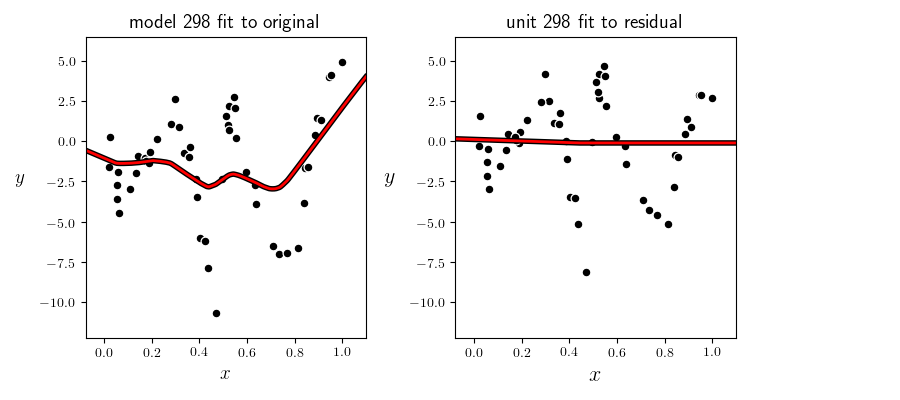
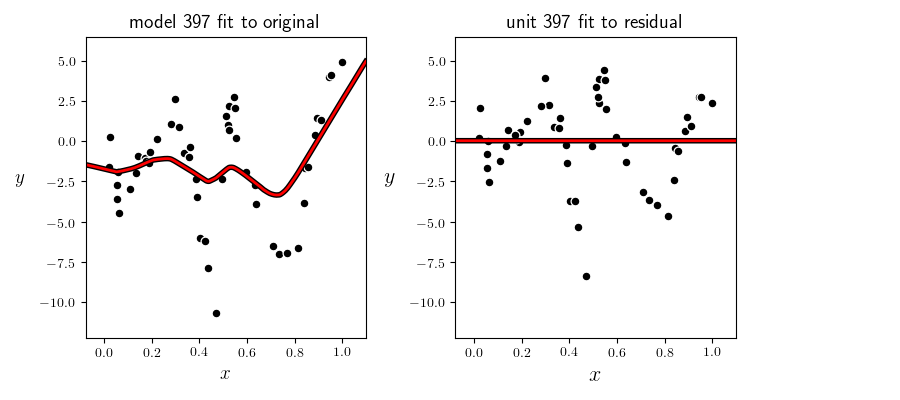
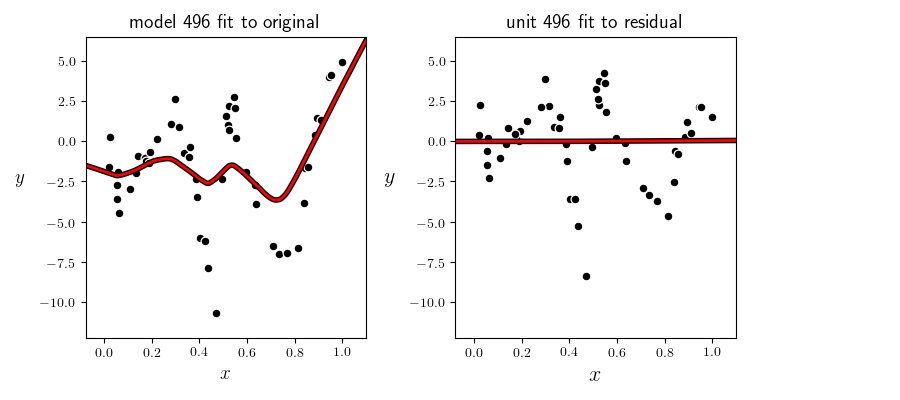
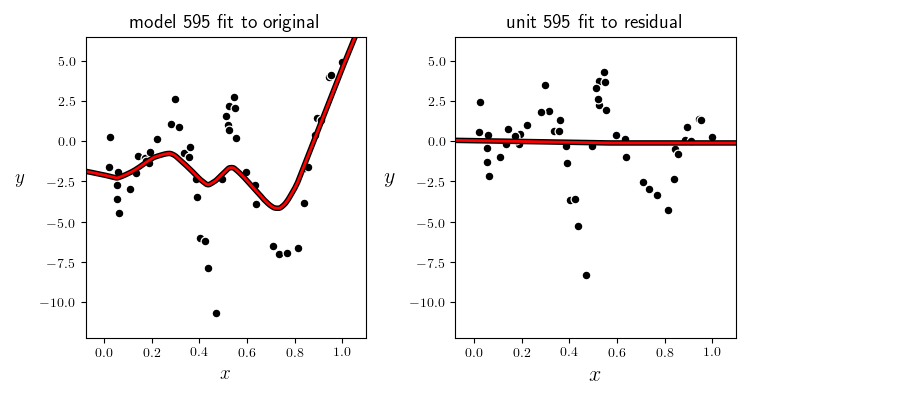
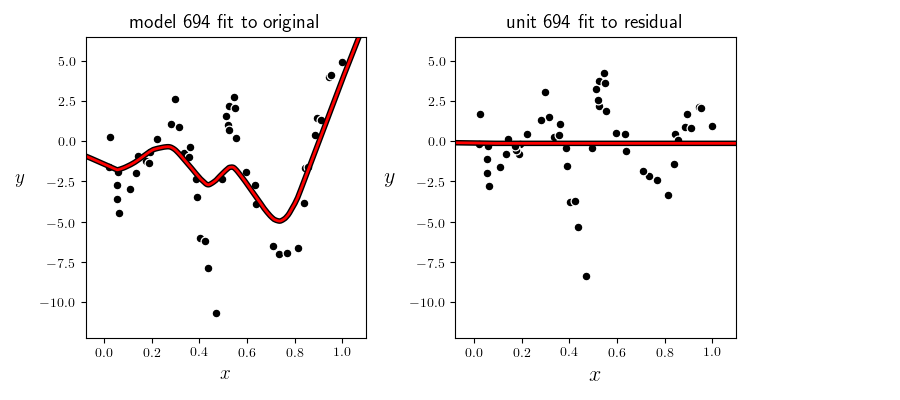
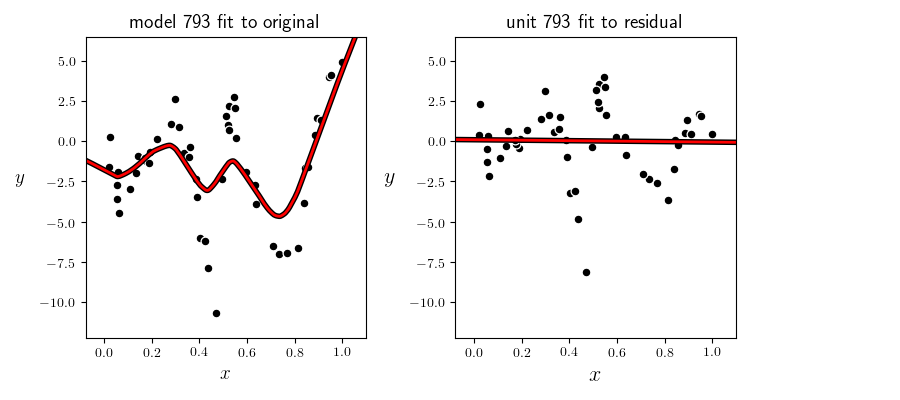
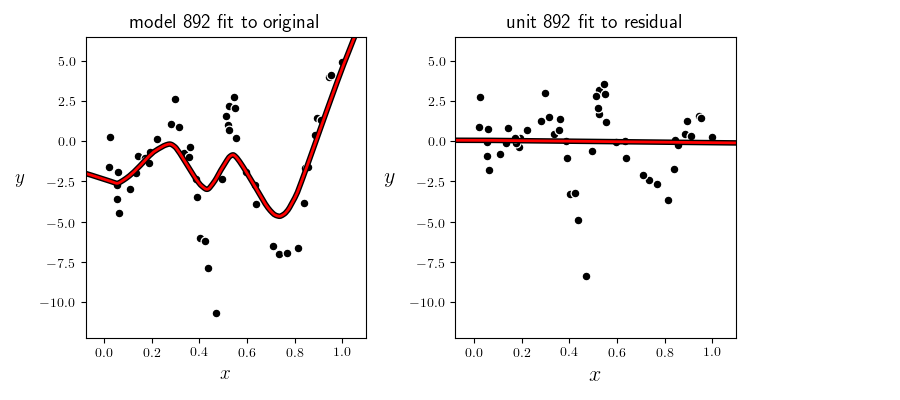
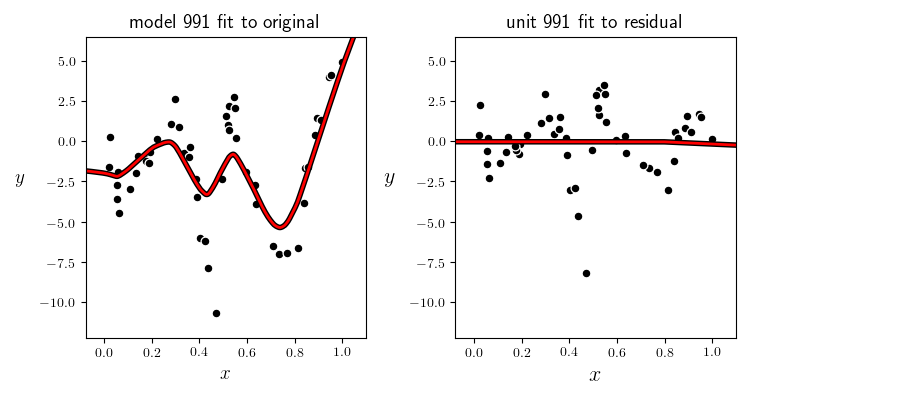
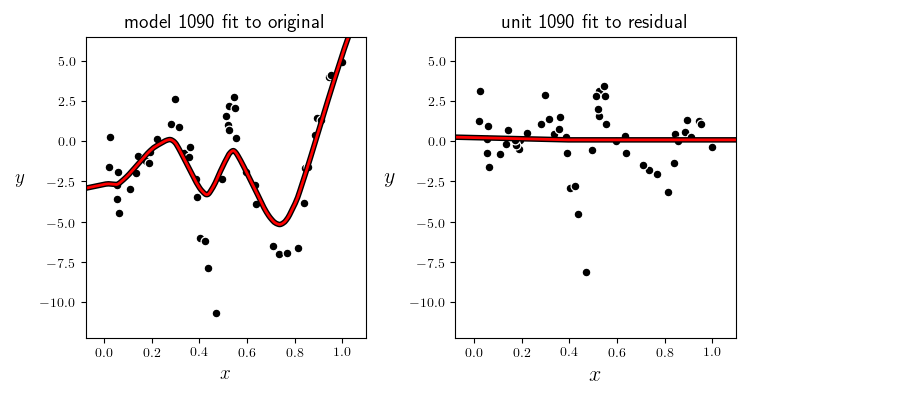
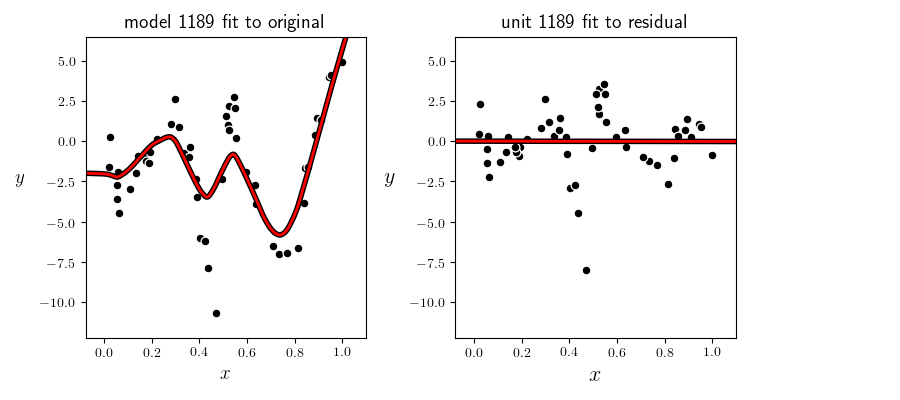
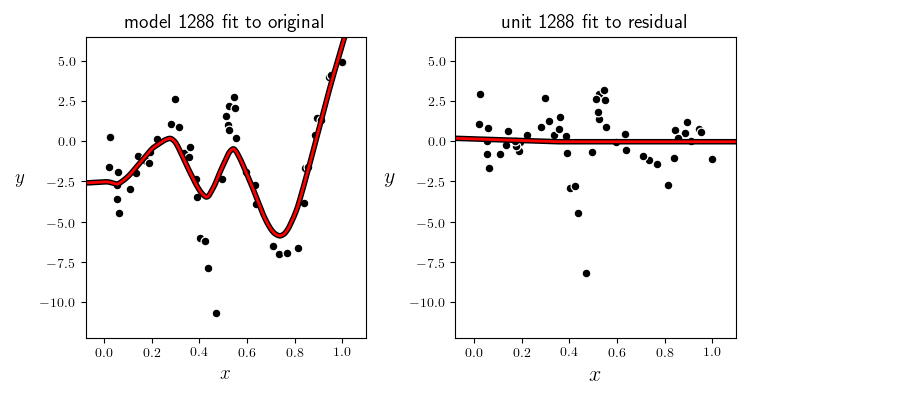
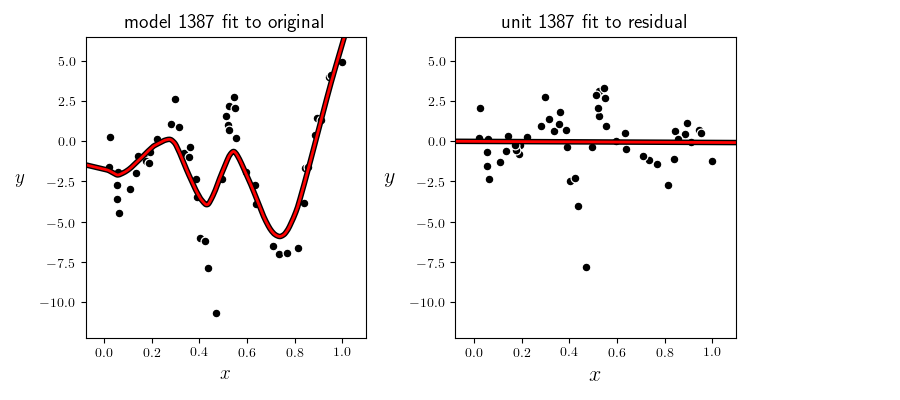
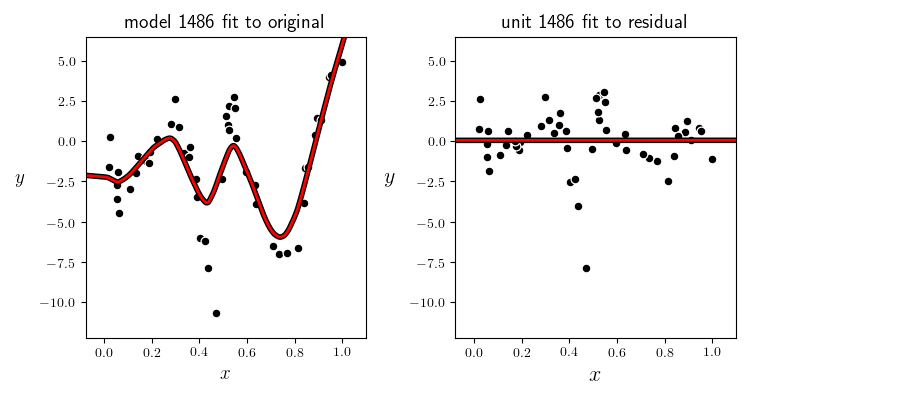
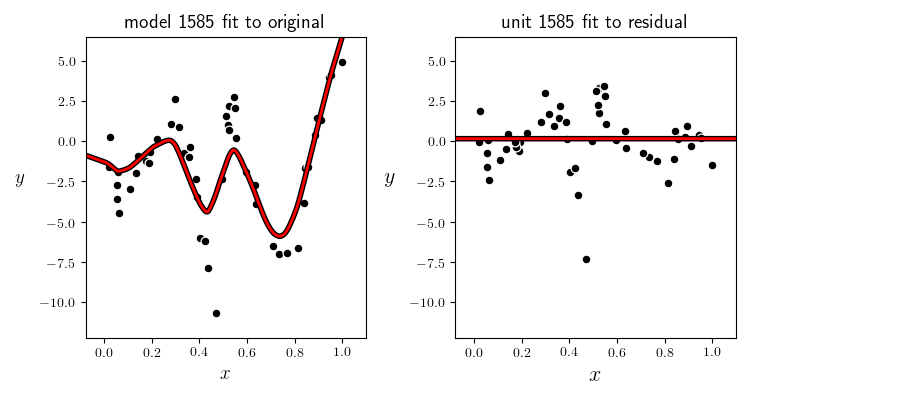
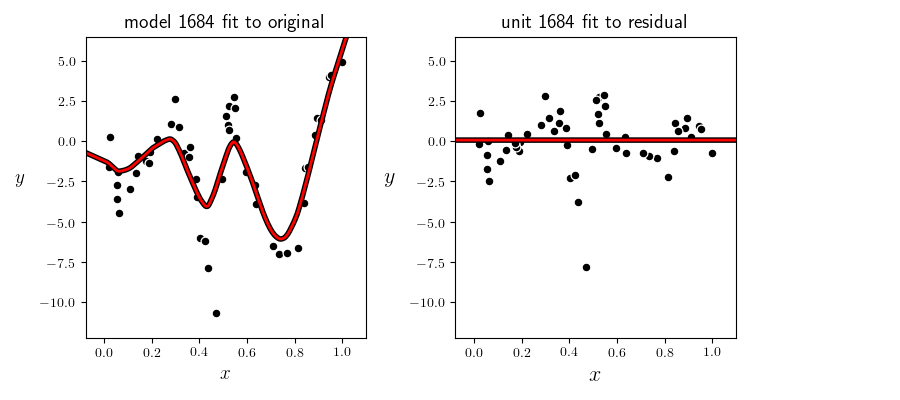
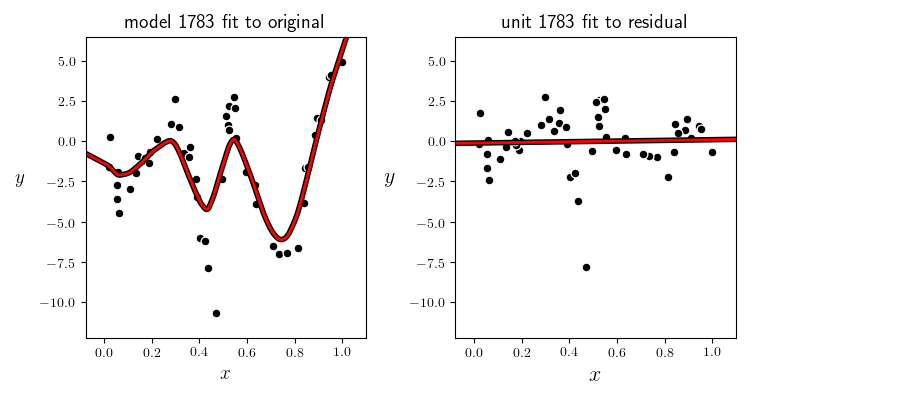
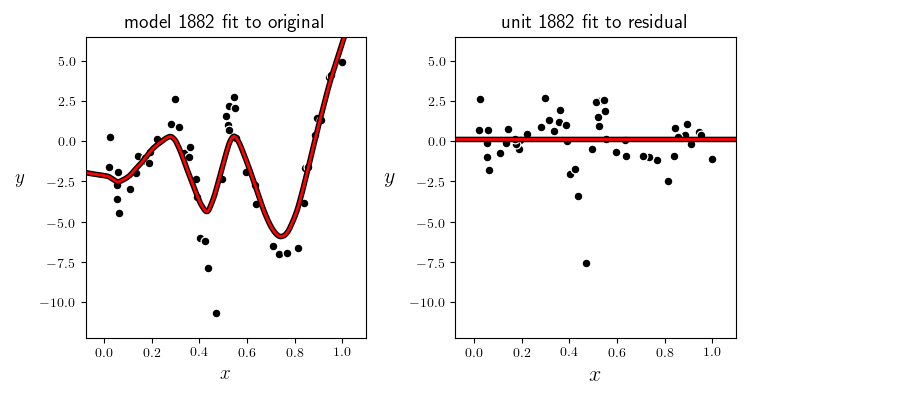
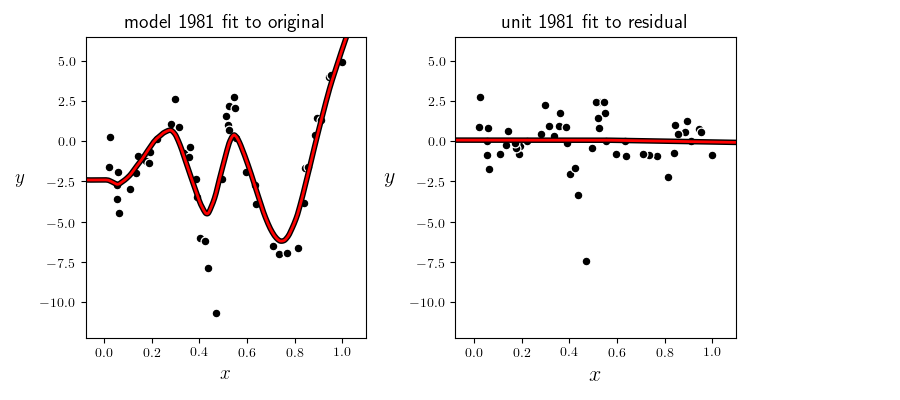
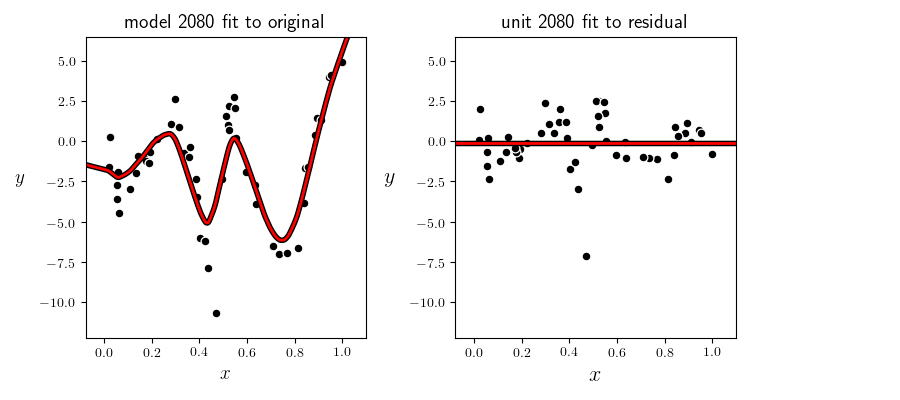
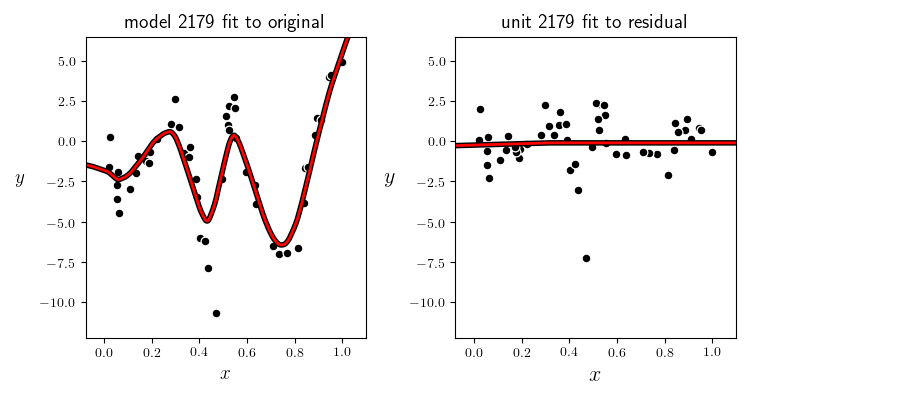
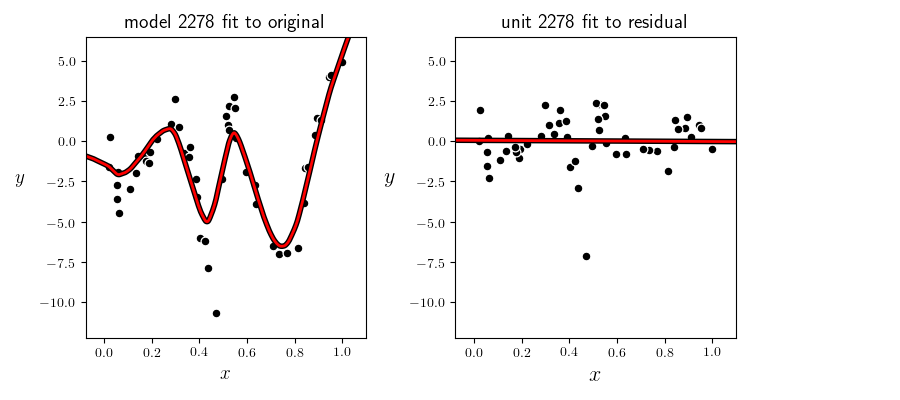
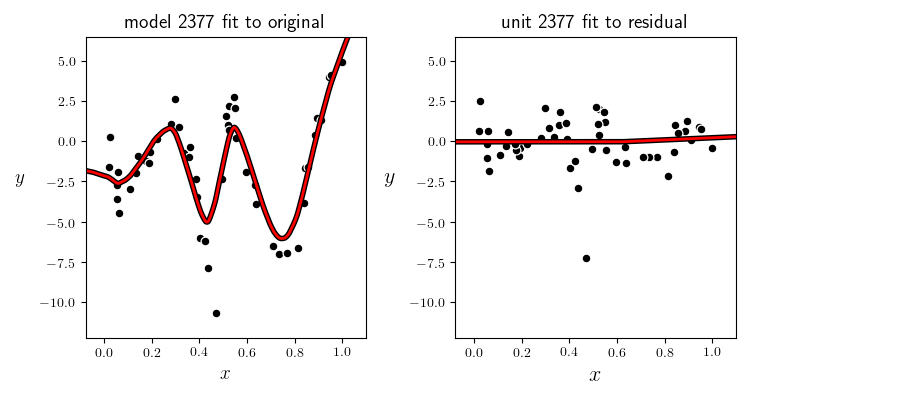
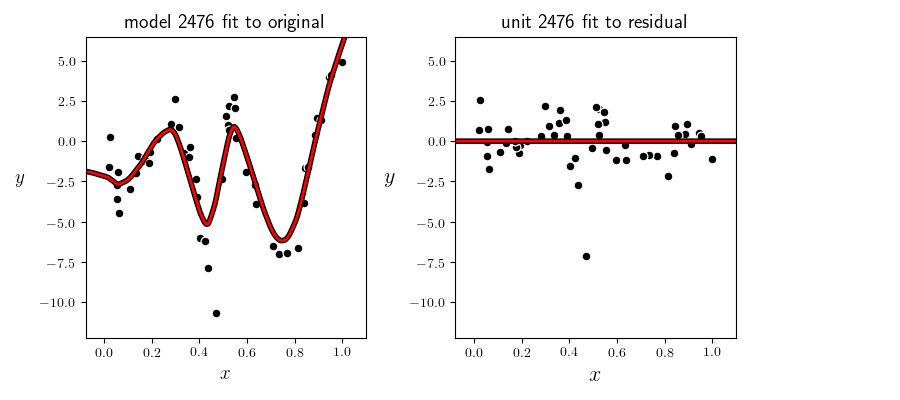
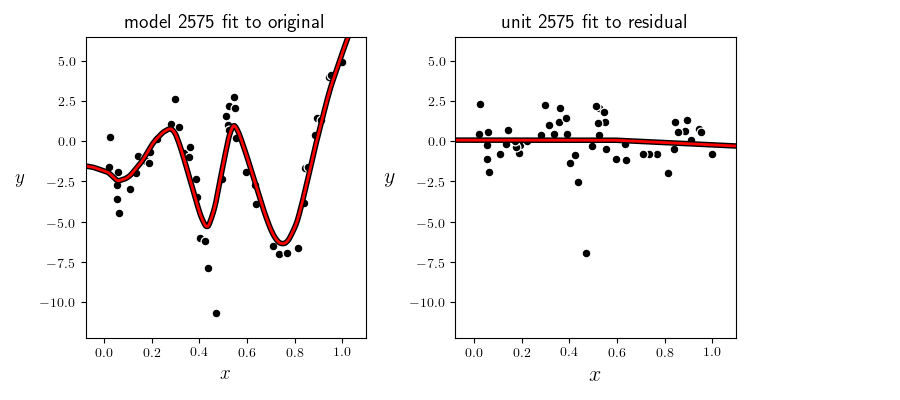
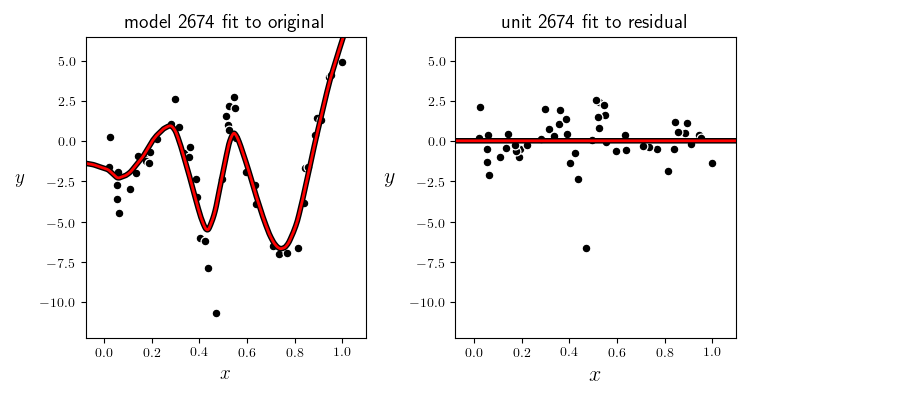
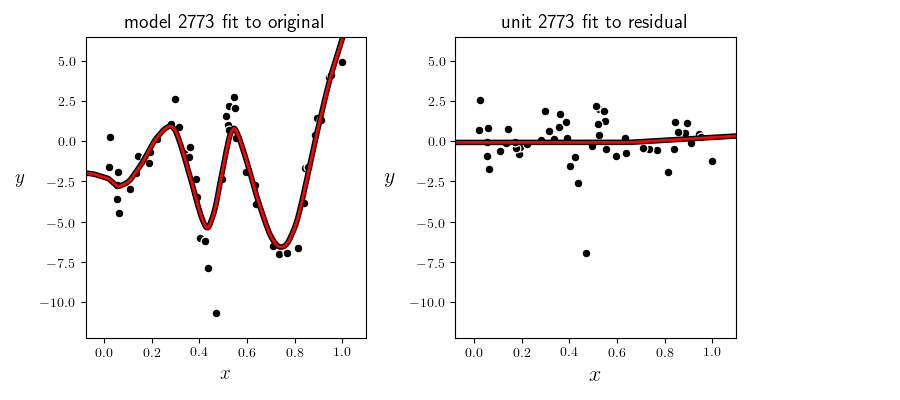
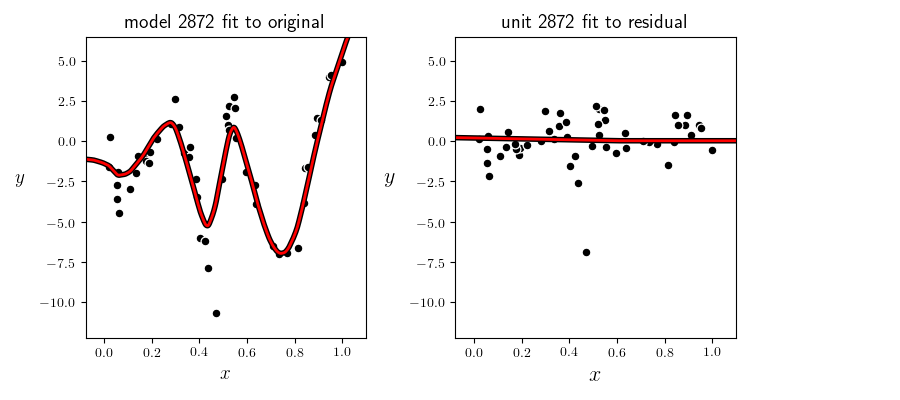
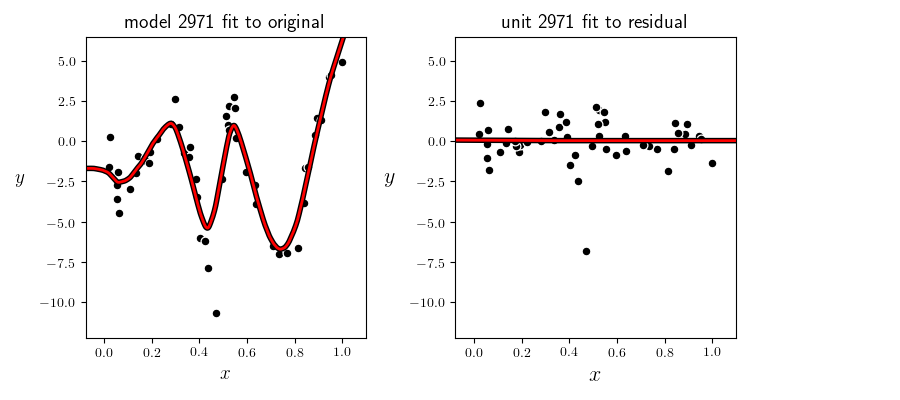
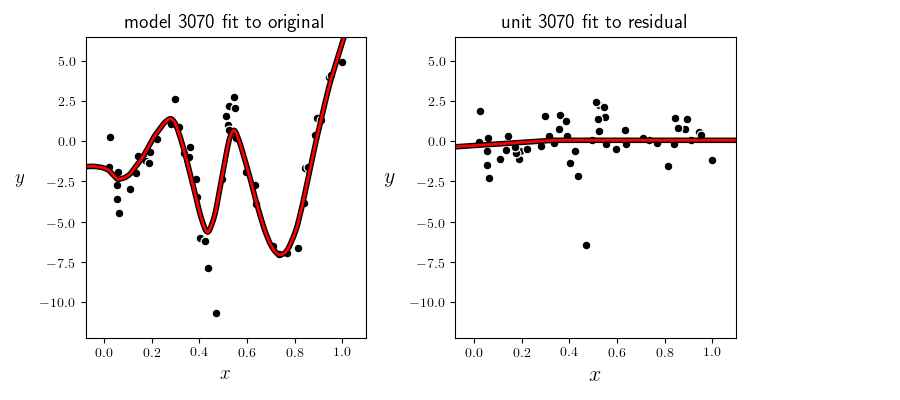
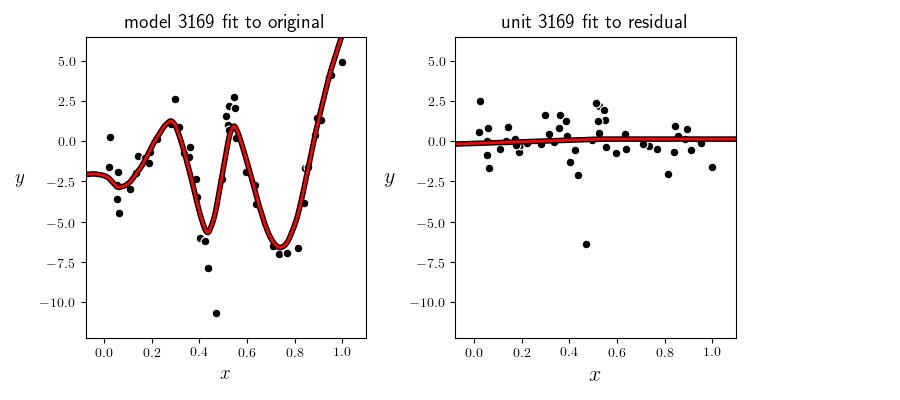
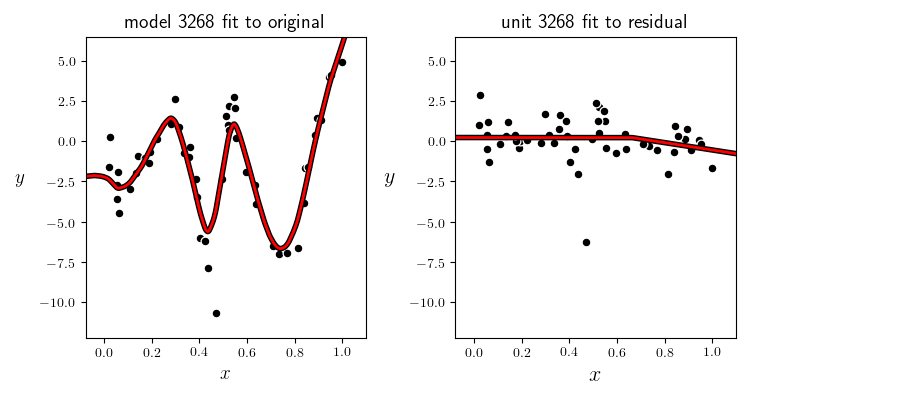
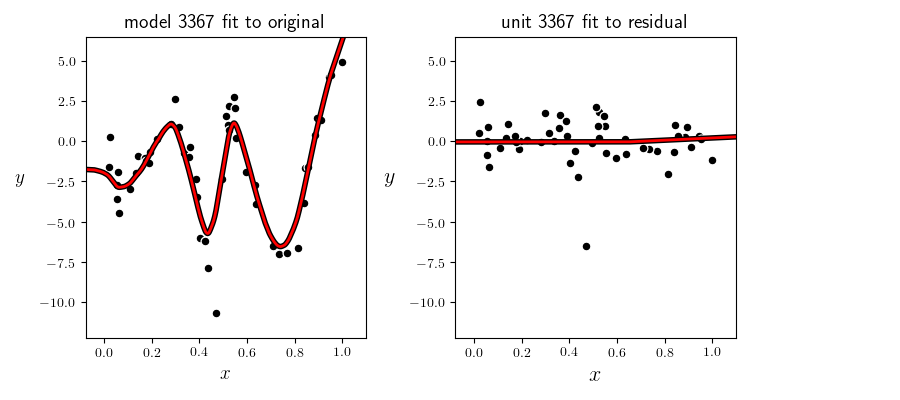
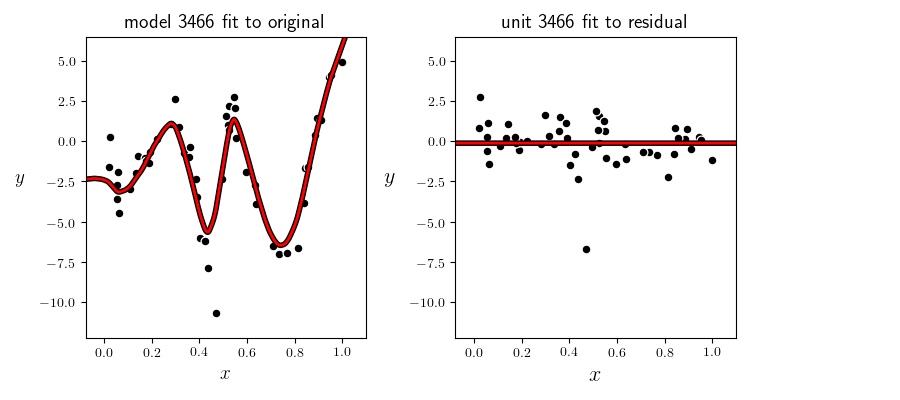
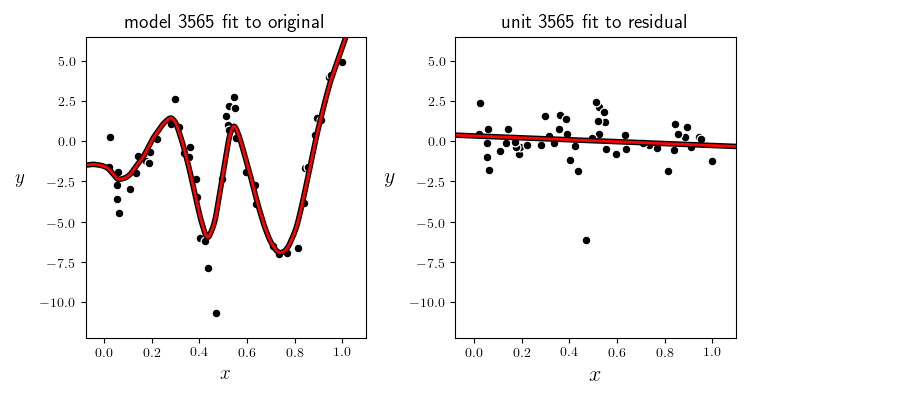
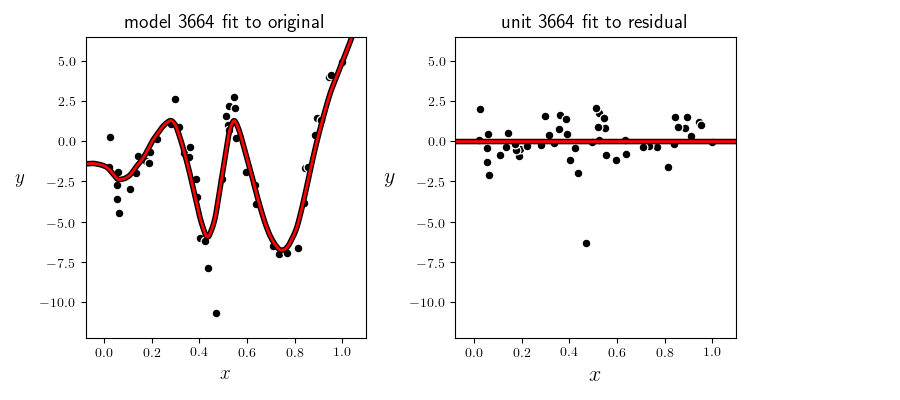
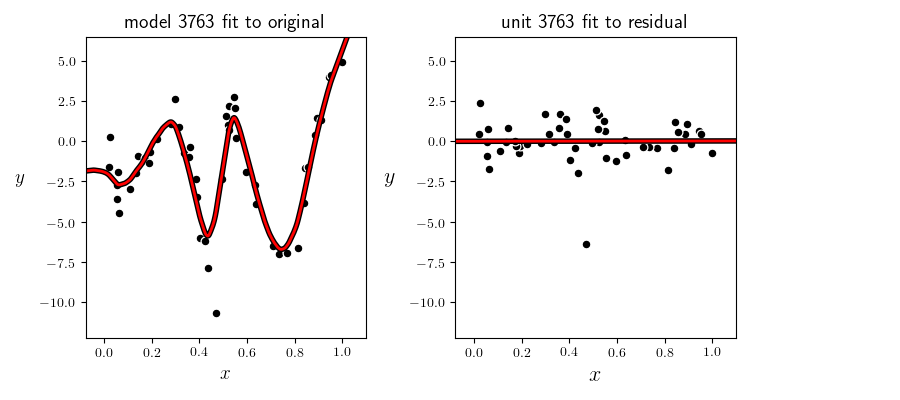
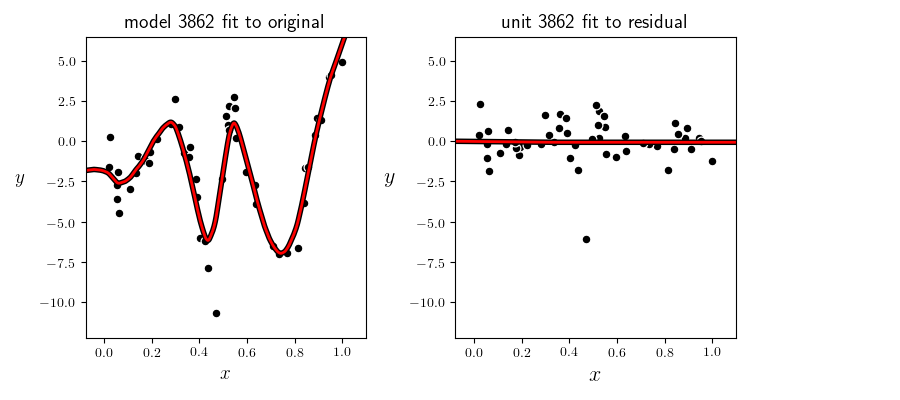
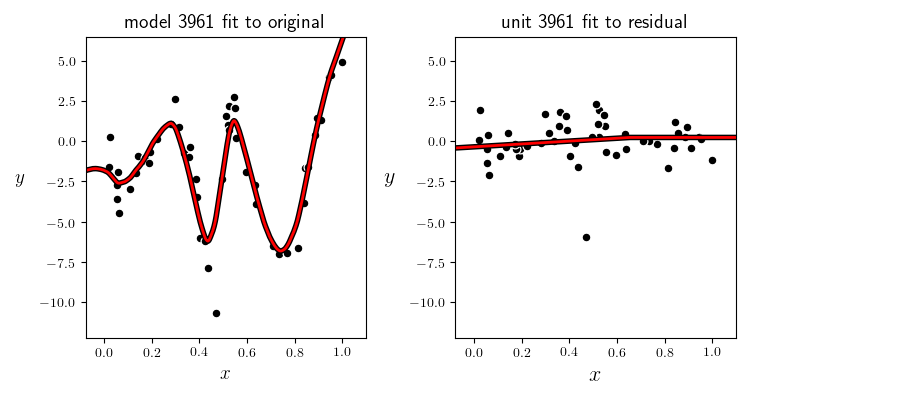
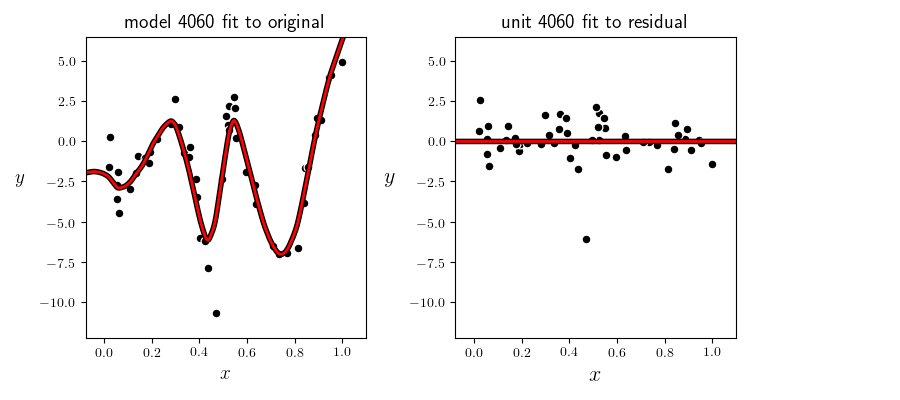
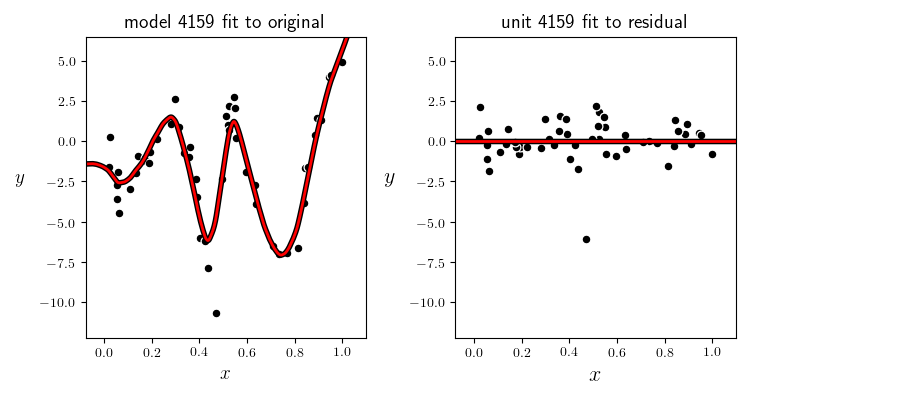
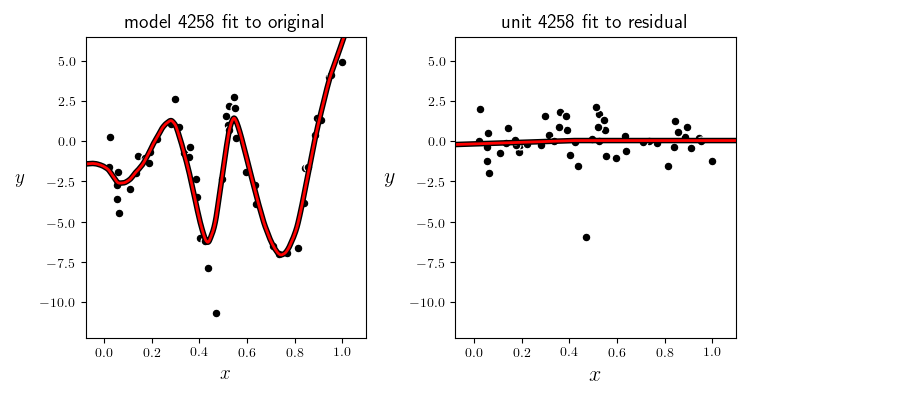
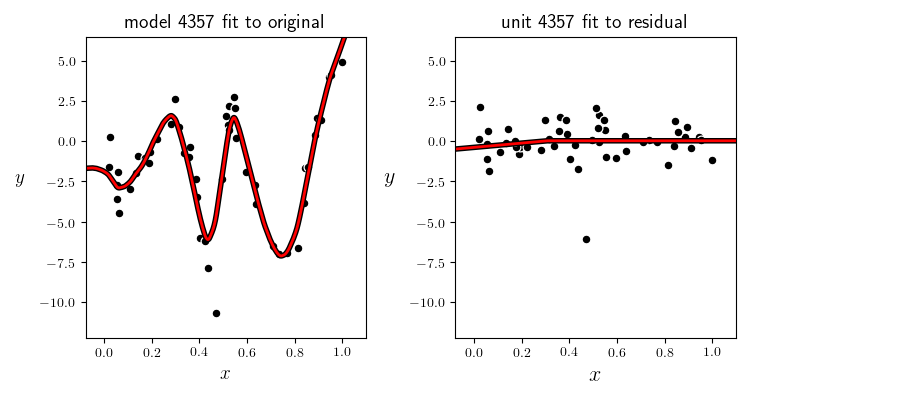
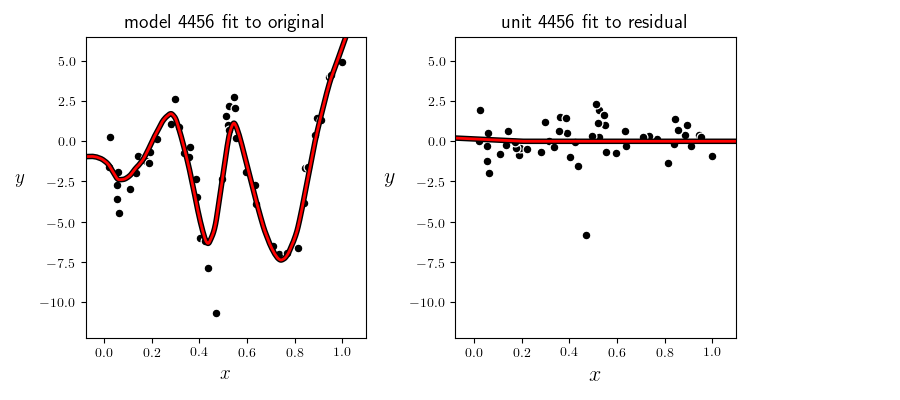
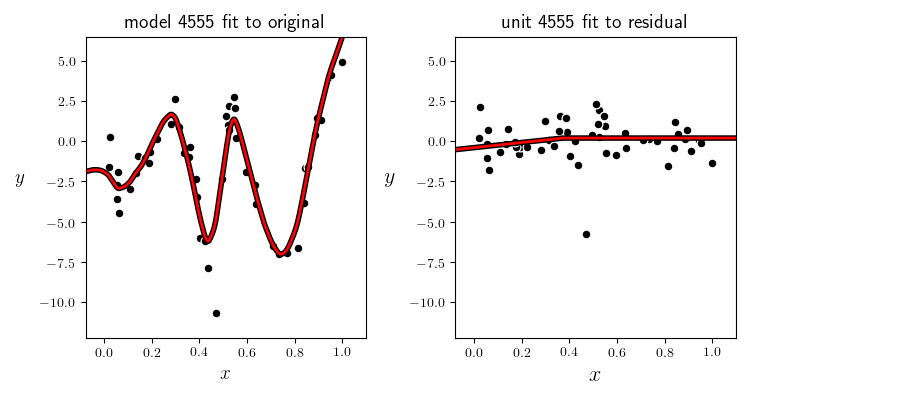
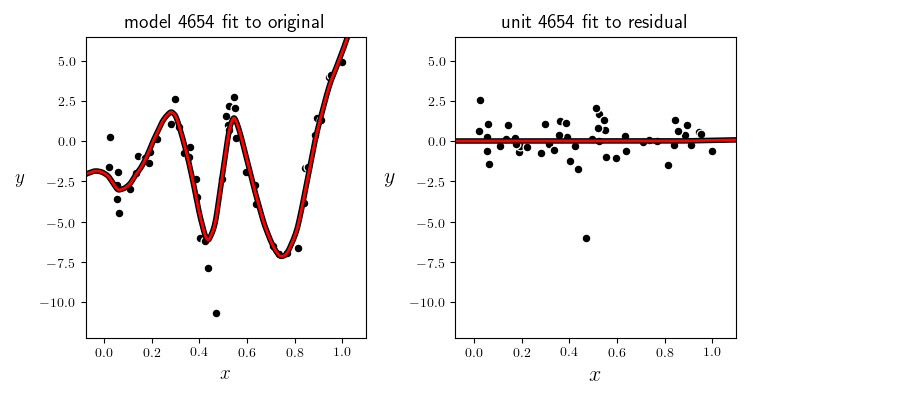
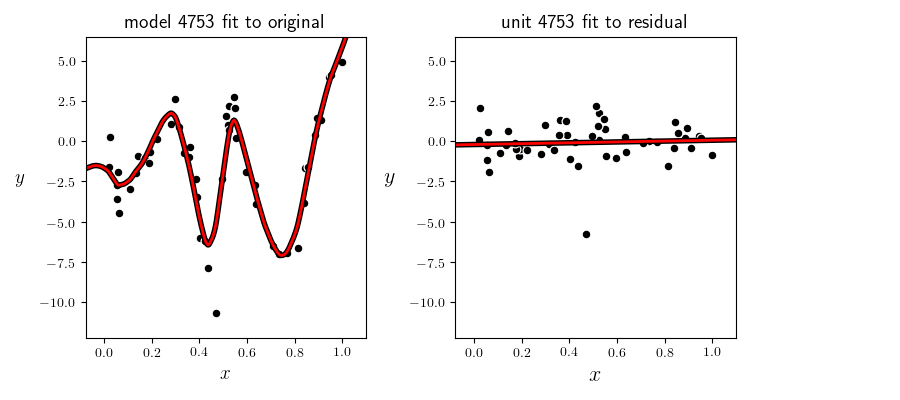
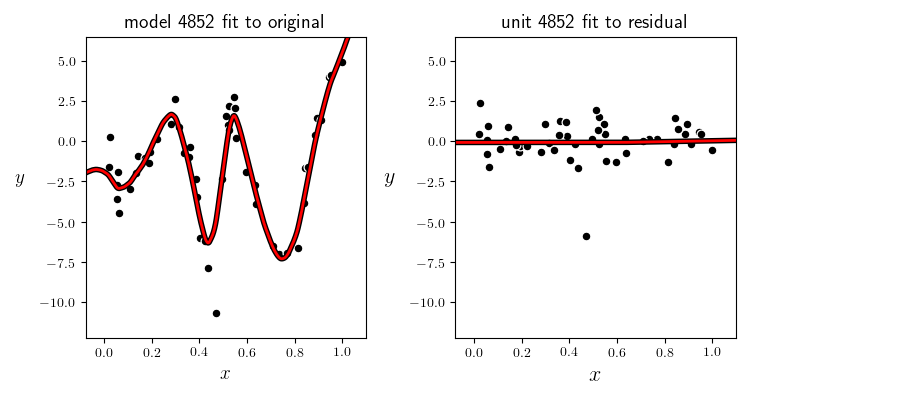

In [15]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'universal_regression_samples_0.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

# boosting procedure
num_units = 5000
runs2 = []
for j in range(num_units):    
    # import the v1 library
    mylib2 = nonlib.library_v1.superlearn_setup.Setup(x,y)

    # choose features
    mylib2.choose_features(name = 'multilayer_perceptron',layer_sizes = [1,1,1],activation = 'relu',scale = 0.5)

    # choose normalizer
    mylib2.choose_normalizer(name = 'standard')
        
    # choose cost
    mylib2.choose_cost(name = 'least_squares')

    # fit an optimization
    mylib2.fit(max_its = 10,alpha_choice = 10**(-1))

    # add model to list
    runs2.append(copy.deepcopy(mylib2))
    
    # cut off output given model
    normalizer = mylib2.normalizer
    ind = np.argmin(mylib2.cost_histories[0])
    weights = mylib2.weight_histories[0][ind]
    y_pred =  mylib2.model(normalizer(x),weights)
    y -= y_pred
    
# animate the business
frames = 50
demo2 = nonlib.boosting_regression_animators.Visualizer(csvname)
demo2.animate_boosting(runs2,frames)

#### <span style="color:#a50e3e;">Example 3. </span> Boosting classification - using high capacity rounds

In this example we illustrate the same kind of boosting performed above with regression, employing single `tanh` units added in one-at-a-time to our `model`, for two class classification.  Here we use a small dataset of $99$ datapoints that has a roughly circular decision boundary (this dataset was first used in the previous Section), and split it randomly into $\frac{2}{3}$ training and $\frac{1}{3}$ validation.  Once again we animate this process over a range boosting steps - here we perform of $30$ of them - where we add $10$ units at-a-time.  As you move the slider from left to right the results of each added unit - in terms of the nonlinear decision boundary and resulting classification - are shown in the top left (where the original data is shown) , top right (where the training data alone is shown), and bottom left (where the validation data is shown) panels.  A plot showing the training / validation errors at each step of the process is shown in the bottom right panel.

Once again here, moving the slider back and forth, we can see that the `model` providing the smallest validation error appears to (more or less) provide the best nonlinearity / decision rule for the entire dataset (i.e., the current data as well as any data that might be generated by the same process in the future).  Here we can see - unsurprisingly given that we add $10$ units per round of boosting - that a single round of boosting provides the lowest validation error.  The amount of capacity we are adding each round, based on the relative simplicity of the dataset, was too large here.  


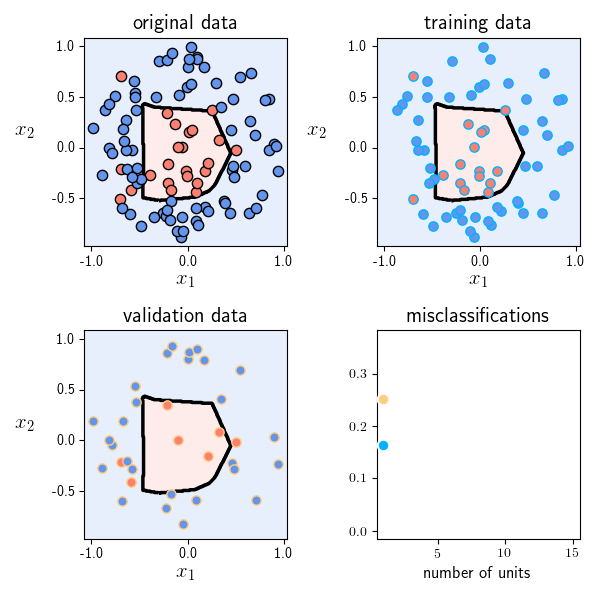
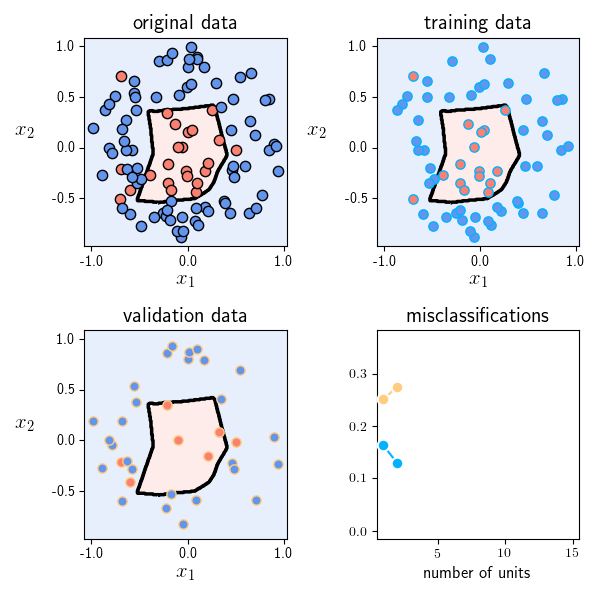
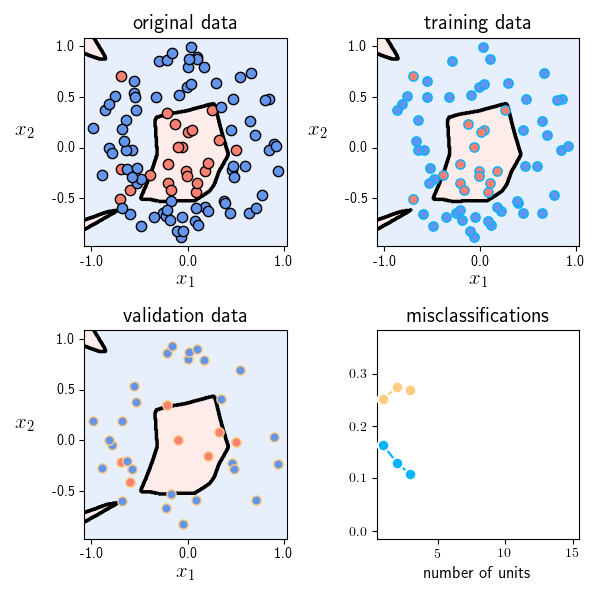
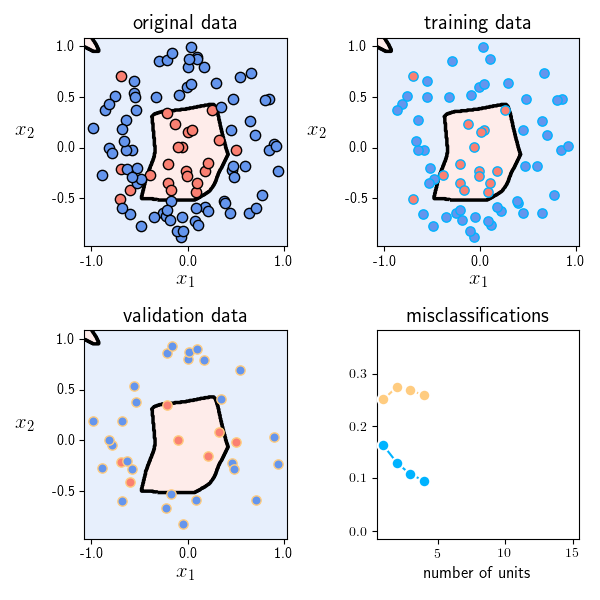
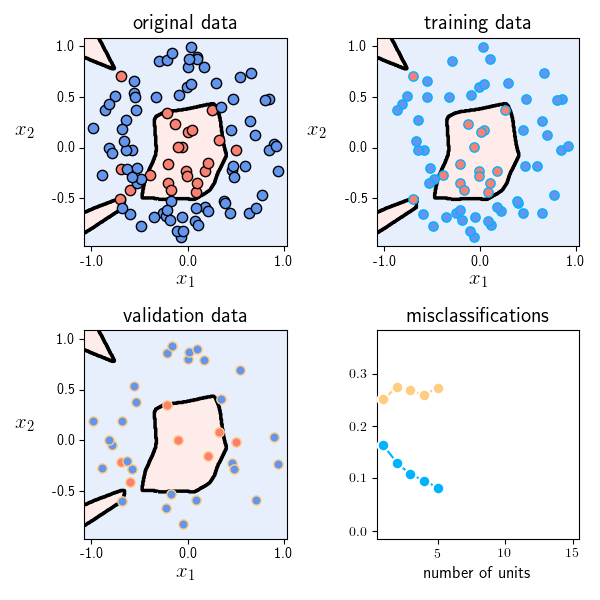
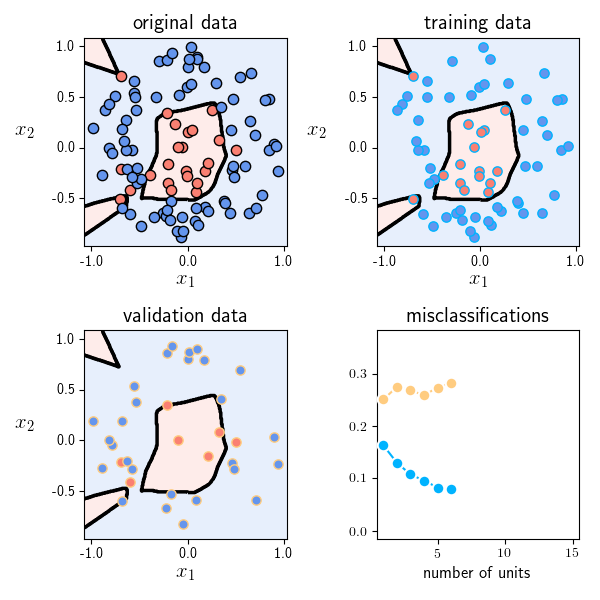
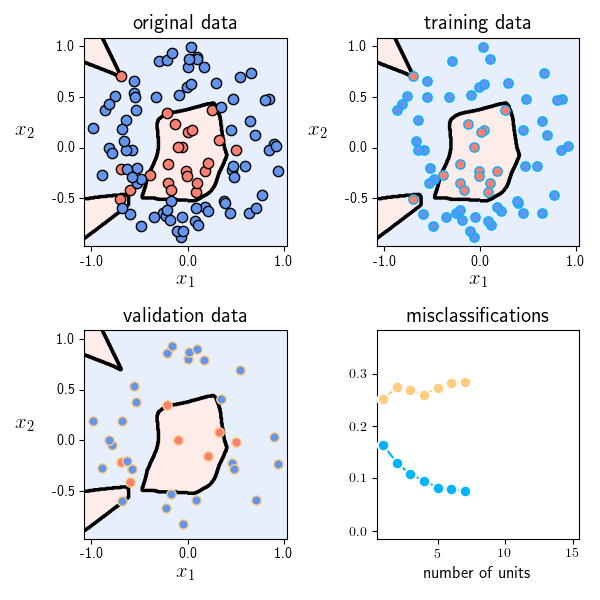
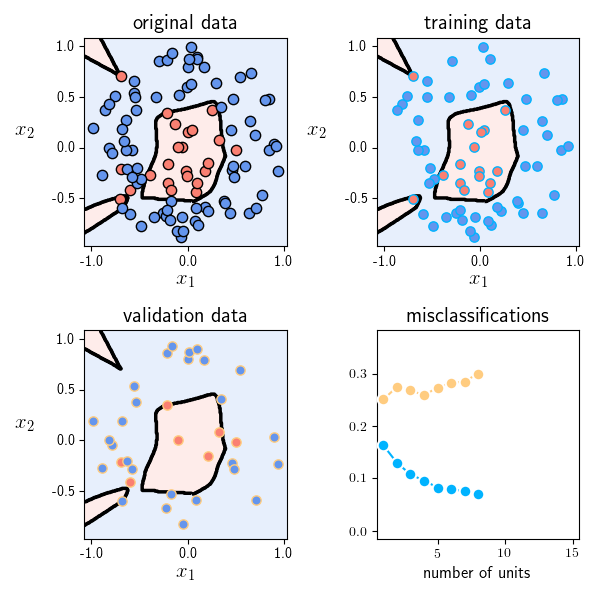
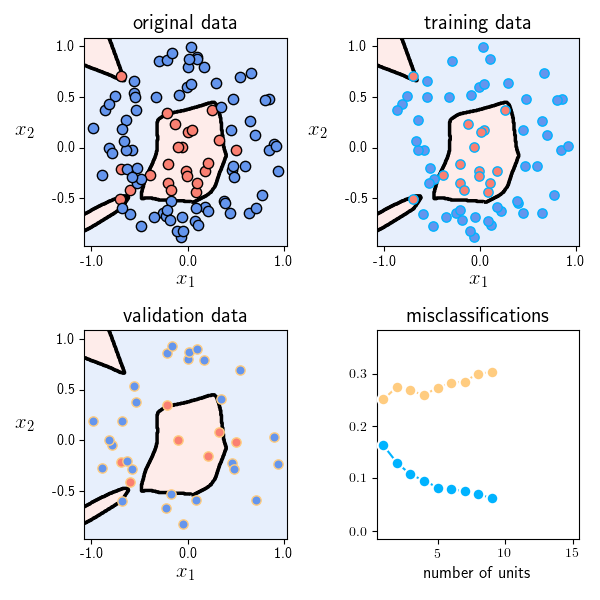
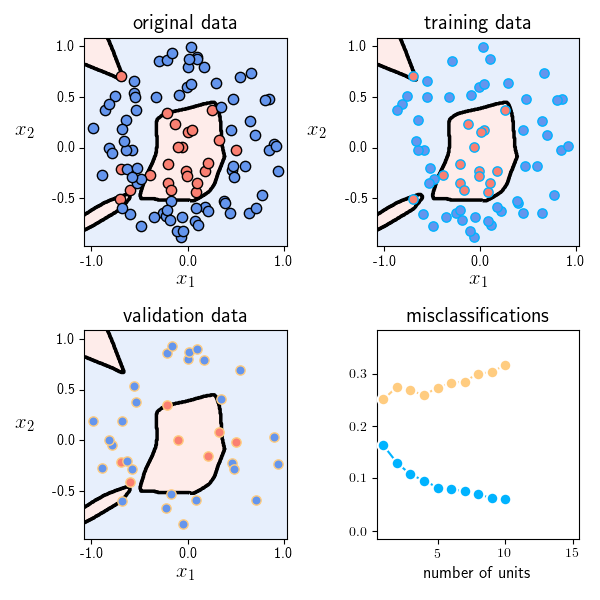
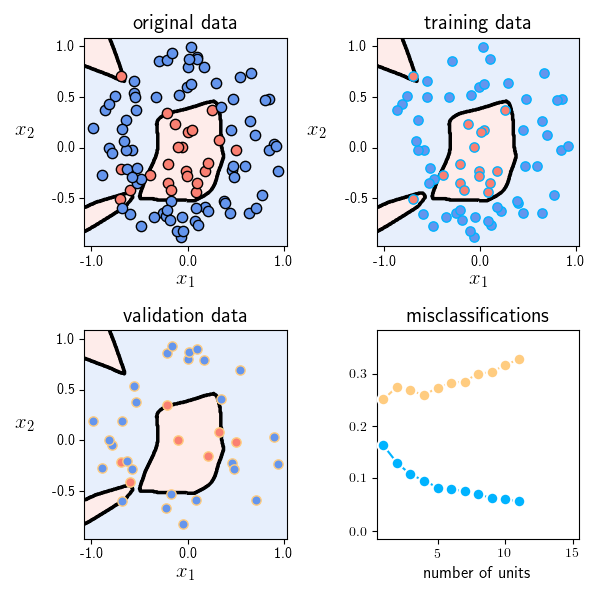
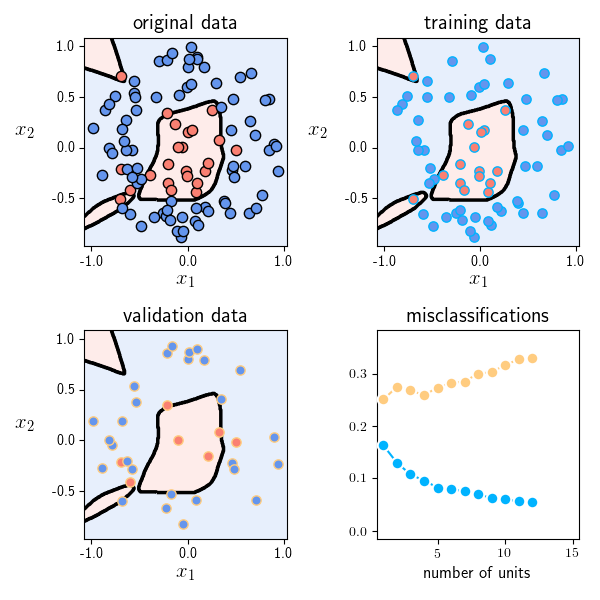
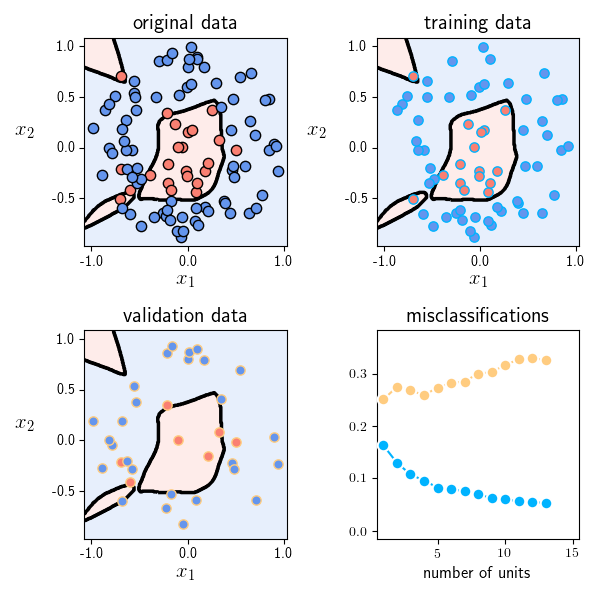
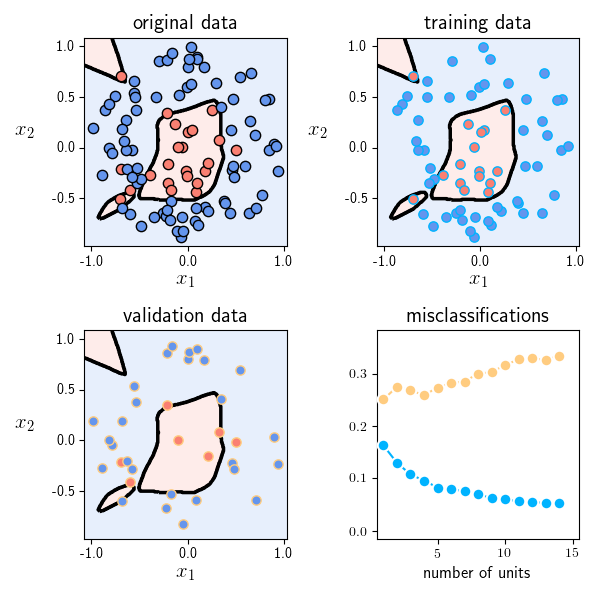
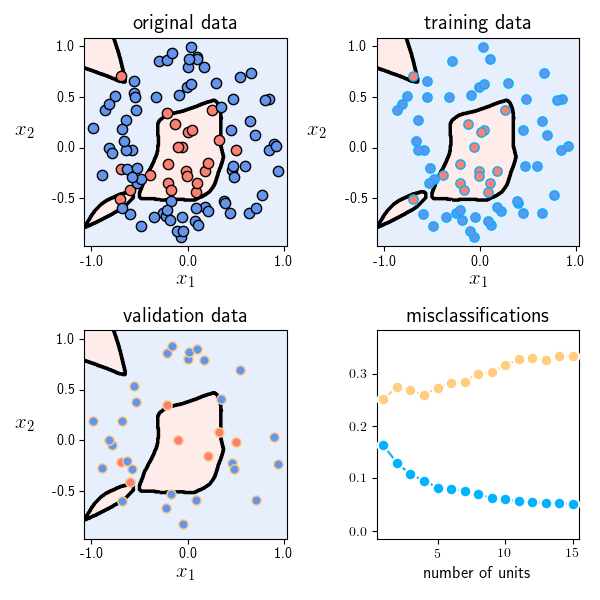

In [96]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

### boosting ###
num_units = 30
runs3 = []
final_model = lambda data: np.zeros((1,data.shape[1]))
for j in range(num_units):    
    print ('unit ' + str(j) + ' added to model')
    # import the v1 library
    mylib3 = nonlib.boost_lib.superlearn_setup.Setup(x,y)

    # choose features
    mylib3.choose_features(name = 'multilayer_perceptron',layer_sizes = [2,10,1],activation = 'relu',scale = 0.5)

    # choose normalizer
    mylib3.choose_normalizer(name = 'standard')
    
    # split into training and validation sets
    if j == 0:
        # make training testing split
        mylib3.make_train_valid_split(train_portion = 0.66)
        train_inds = mylib3.train_inds
        valid_inds = mylib3.valid_inds

    else: # use split from first run for all further runs
        mylib3.x_train = runs3[j-1].x[:,train_inds]
        mylib3.y_train = runs3[j-1].y[:,train_inds]
        mylib3.x_valid = runs3[j-1].x[:,valid_inds]
        mylib3.y_valid = runs3[j-1].y[:,valid_inds]
        mylib3.train_inds = train_inds
        mylib3.valid_inds = valid_inds
    
    # in second round and beyond add in contribution of previous model
    # when choosing cost
    mylib3.choose_cost(name = 'softmax',runs = runs3)    
    
    # fit an optimization
    mylib3.fit(max_its = 3000,alpha_choice = 10**(-1))
    runs3.append(mylib3)
    
# report update and clear cell output
print ('finished all ' + str(num_units) + ' steps')
time.sleep(1.5)
clear_output()

# compute number of units in each degree d polynomoial
blah = np.arange(num_units)

# load up animator
demo3 = nonlib.boosting_classification_animator.Visualizer(csvname)

# animate based on the sample weight history
frames = 15
demo3.animate_trainval_boosting(runs3,frames,num_units)

## 12.7.3  Summary

Here we have learned about *boosting*, a way of fine-tuning the capacity of a `model` by adding units one-at-a-time (or in general several at a time) to progressively build up `model` capacity.  This approach works particularly well when using low-capacity units, like the `tanh` or `relu` single layer units we have used in the examples here.  Using such units allows for fine-tuning of capacity, and for the determination of `models` with low validation error.  However when using more flexible units - like e.g., deep neural networks or tree-based approximators (as we will learn about in the Chapters that follow) - this approach provides a coarser amount of control since adding just a single unit can substantially increase `model` capacity, meaning that the 'right' amount of nonlinearity necessary to minimize validation error is easier to miss.  We actually saw this phenomenon in our final example, where in each round of boosting we added $10$ `tanh` units.  

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.